***
# 0 Dependencies import

 ## 0.1 Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

import geopandas as gpd

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)


***
## 0.2 Features selection

In [2]:


def get_categorical_features_name(
    dataset,
    split_by_unique_count=True,
    split_count=10
):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name
                        if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values.tolist()


In [3]:


def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(
        ["int64", "float64"]
        ).columns.values.tolist()
    return features_name


In [4]:


def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}."
          .format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}"
                  .format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}".
              format(selected_feature, high_score))
    return selected_features


***
## 0.3 Pipeline construction

In [5]:


def evaluate(dataset, model, scoring="neg_root_mean_squared_error"):
    numerical_cols = get_numerical_features_name(dataset)

    X = dataset[numerical_cols]

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean")),
        ("minmax_scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    preprocessor.fit(X)
    array_preproc = preprocessor.transform(X)
    data_preproc = pd.DataFrame(data=array_preproc, columns=X.columns)

    return pipeline, preprocessor, data_preproc


In [6]:


def pca_preprocessor(dataset):
    num_cols = get_numerical_features_name(dataset)
    categ_cols, _ = get_categorical_features_name(dataset)

    num_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="mean")),
        ("scaler_01", StandardScaler())
    ])

    categ_pipe = Pipeline(steps=[
        ("imputer_01", SimpleImputer(strategy="most_frequent")),
        ("encoder_01", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, num_cols),
        ("categ_pipe", categ_pipe, categ_cols)
    ])

    return preprocessor, num_cols, categ_cols


In [7]:


def preprocess_data(dataset):
    preprocessor, num_cols, categ_cols = pca_preprocessor(dataset)

    raw_preprocessed_data = preprocessor.fit_transform(dataset)

    if categ_cols:
        categ_cols_preprocessed = preprocessor.transformers_[1][1][
            "encoder_01"
            ].get_feature_names_out(categ_cols).tolist()
    else:
        categ_cols_preprocessed = []

    col_names = num_cols + categ_cols_preprocessed

    preprocessed_data = pd.DataFrame(
        data=raw_preprocessed_data,
        columns=col_names)

    return preprocessed_data


***
## 0.4 Cluster evaluation

In [8]:


def elbow_plot(range, data, figsize=(10, 10)):
    intertia_list = []
    for n in range:
        kmeans = KMeans(n_clusters=n, random_state=1)
        kmeans.fit(data)
        intertia_list.append(kmeans.inertia_)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=intertia_list, x=range, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range))
    fig.show()


In [9]:


def silhouette_plot(
    range, data,
    n_cols=2,
    figsize=(20, 10),
    wspace=0.35,
    hspace=0.35
):
    if range[0] == 0:
        raise Exception("Range must not include 0")

    n_rows = ceil(len(range)/n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for n in range:
        kmeans = KMeans(n, random_state=1)

        plt.subplot(n_rows, n_cols, index+1)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick")
        sv.fit(data)

        index += 1
    plt.show()

In [10]:


def display_clusters(dataset_preproc, n_clusters):
    pca, pca_data, loadings = apply_pca(
        dataset_preproc,
        dataset_preproc.columns,
        2)
    reduced_data = pca_data.to_numpy()
    model = KMeans(init="k-means++", n_clusters=n_clusters)
    model.fit(reduced_data)

    h = 0.02

    x_min = reduced_data[:, 0].min() - 1
    x_max = reduced_data[:, 0].max() + 1

    y_min = reduced_data[:, 1].min() - 1
    y_max = reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z, interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower"
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10
    )

    plt.title("K-means clustering, PCA reduced dataset")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()


***
## 0.5 Dimensionality reduction

In [11]:


def scree_plot(dataset, figsize=(15, 5)):
    pca = PCA()
    pca.fit(dataset)

    plt.figure(figsize=figsize)
    explain_variance = pd.Series(pca.explained_variance_ratio_)
    explain_variance.plot(kind="bar", alpha=0.7)

    total = 0
    var_ls = []
    for x in explain_variance:
        total = total + x
        var_ls.append(total)

    pd.Series(var_ls).plot(marker="o", alpha=0.7)
    plt.xlabel("Principle Components", fontsize="x-large")
    plt.ylabel("Percentage Variance Explained", fontsize="x-large")
    plt.title("Scree plot", fontsize="xx-large")
    plt.show()

    return pca


In [12]:


def apply_pca(dataset, columns, n_components):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(dataset[columns])
    components_name = [f"PC{i+1}" for i in range(pca_data.shape[1])]
    pca_data = pd.DataFrame(data=pca_data, columns=components_name)
    loadings = pd.DataFrame(
        data=pca.components_.T,
        columns=components_name,
        index=columns)
    return pca, pca_data, loadings


In [13]:


def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_

    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cumulative_variance = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs


***
## 0.6 RFM

In [14]:


def rfm_distplot(dataset, customer_id, figsize=(20, 5)):
    warnings.filterwarnings('ignore')
    dataset = dataset.loc[:, dataset.columns.difference(customer_id)]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for i, feature in enumerate(dataset.columns):
        sns.distplot(dataset[feature], ax=axes[i])


In [15]:


def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()


In [16]:


def elbow(dataset, k=(2, 12)):
    model = KMeans(random_state=1)
    elbow_visualizer = KElbowVisualizer(model, k=k)

    elbow_visualizer.fit(dataset)
    elbow_visualizer.poof()


In [17]:


def silhouette(dataset, n):
    model = KMeans(n, random_state=1)
    silhouette_visualizer = SilhouetteVisualizer(model)

    silhouette_visualizer.fit(dataset)
    silhouette_visualizer.poof()


In [18]:


def explain(dataset, dataset_preproc):
    model = KMeans(n_clusters=4, random_state=1).fit(dataset_preproc)
    data_explain = dataset
    data_explain["Cluster"] = model.labels_

    data_explain_melt = pd.melt(
        data_explain,
        id_vars=["customer_id", "Cluster"],
        value_vars=["Récence", "Fréquence", "Montant"],
        var_name="Features",
        value_name="Value")
    sns.lineplot("Features", "Value", hue="Cluster", data=data_explain_melt)
    plt.legend()

    return data_explain.groupby("Cluster").agg({
        "Récence": ["mean", "min", "max"],
        "Fréquence": ["mean", "min", "max"],
        "Montant": ["mean", "min", "max", "count"]
    })


***
## 0.7 Explainability

In [19]:


def explain_global(dataset, dataset_preproc, clusters, figsize=(30, 10)):
    model = KMeans(n_clusters=clusters, random_state=1).fit(dataset_preproc)
    data_explain = dataset_preproc.copy()
    data_explain.loc[:, "customer_id"] = dataset.loc[:, "customer_id"]
    data_explain.loc[:, "Cluster"] = model.labels_

    data_explain_melt = pd.melt(
        data_explain,
        id_vars=["customer_id", "Cluster"],
        value_vars=dataset_preproc.columns,
        var_name="Features",
        value_name="Value")

    plt.figure(figsize=figsize)
    sns.lineplot(
        x="Features",
        y="Value",
        hue="Cluster",
        data=data_explain_melt,
        palette="deep")
    plt.legend()

    ops = {}
    for col in dataset_preproc.columns:
        ops[col] = ["mean", "min", "max", "count"]

    return data_explain.groupby("Cluster").agg(ops)


***
# 1 Configuration

In [20]:
config = {
    "overview": {

    },
    "fe": {
        "id": False,
        "volume": False,
        "order_purchase_timestamp": False,
        "shipping_limit_date": False,
        "order_estimated_delivery_date": False,
        "price_agg": False,
        "last_order_datetime": False,
        "frequency": False
    },
    "model": {
        "rfm_raw": {
            "preparation": True,
            "n_cluster": True,
            "silhouette": False,
            "explain": True,
            "persona": True
        },

    },
    "geo": {
        "preproc": True,
        "arange": True,
        "all": True,
        "per_cluster": True
    },
    "global": {
        "do": True,
        "elbow": True,
        "explain_plot": True,
        "features_plot": True,
        "cluster_plot": True
    },
    "maintenance": {
        "do": True
    }
}



***
# 2 Data loading

In [21]:


data = pd.read_csv("data/data_cleaned.csv", delimiter=",")


***
# 3 Overview

In [22]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111705 entries, 0 to 111704
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111705 non-null  object 
 1   customer_id                    111705 non-null  object 
 2   order_status                   111705 non-null  object 
 3   order_purchase_timestamp       111705 non-null  object 
 4   order_approved_at              111690 non-null  object 
 5   order_delivered_carrier_date   110530 non-null  object 
 6   order_delivered_customer_date  109366 non-null  object 
 7   order_estimated_delivery_date  111705 non-null  object 
 8   customer_unique_id             107697 non-null  object 
 9   customer_zip_code_prefix       107697 non-null  float64
 10  customer_city                  107697 non-null  object 
 11  customer_state                 107697 non-null  object 
 12  review_id                     

In [23]:
data.describe()


,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,107697.000000,111705.000000,111705.000000,111702.000000,111705.00000,111705.000000,111705.000000,111323.000000,110116.000000,110116.000000,110116.000000,111679.000000,111687.000000,111687.000000,111687.000000,111705.000000
mean,35174.843524,4.033597,1.022640,3.000116,177.04113,1.195273,120.556914,20.057779,48.776390,787.762478,2.209988,2092.554187,30.143616,16.586111,22.994332,24447.946896
std,29885.219509,1.387014,0.256334,2.794302,269.13137,0.689177,182.507246,15.788333,10.025996,651.996358,1.721755,3750.548184,16.141022,13.442283,11.706423,27605.113502
min,1003.000000,1.000000,1.000000,1.000000,0.01000,1.000000,0.850000,0.010000,5.000000,4.000000,1.000000,2.000000,7.000000,2.000000,6.000000,1001.000000
25%,11340.000000,4.000000,1.000000,1.000000,64.01000,1.000000,39.900000,13.085000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000
50%,24350.000000,5.000000,1.000000,2.000000,112.42000,1.000000,74.990000,16.290000,52.000000,602.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13566.000000
75%,59075.000000,5.000000,1.000000,4.000000,193.32000,1.000000,134.900000,21.160000,57.000000,986.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000
max,99990.000000,5.000000,27.000000,24.000000,13664.08000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000


In [24]:
data.describe(include="object")


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,review_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_type,product_id,seller_id,shipping_limit_date,product_category_name,seller_city,seller_state
count,111705,111705,111705,111705,111690,110530,109366,111705,107697,107697,107697,111705,13416,47402,111705,111705,111705,111705,111705,111705,110116,111705,111705
unique,97916,97916,7,97370,89533,80449,95021,449,94655,4107,27,97454,4495,35618,632,97292,4,32789,3090,92642,73,611,23
top,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2018-02-24 03:20:27,2018-05-09 15:48:00,2017-07-31 18:03:02,2017-12-20 00:00:00,4546caea018ad8c692964e3382debd19,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,Recomendo,Muito bom,2017-12-19 00:00:00,2017-07-30 14:19:07,credit_card,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,cama_mesa_banho,sao paulo,SP
freq,21,21,109367,21,23,48,21,600,21,16966,45365,21,468,253,513,21,84471,524,2014,21,10982,27745,79661


***
# 4 Feeture engineering

## 4.0 Remove *_id

In [25]:


def fe_id_remove(dataset, diff=[]):
    id_cols = dataset.columns[dataset.columns.str.contains("_id")]
    id_cols = id_cols.difference(diff)
    dataset.drop(columns=id_cols, inplace=True)
    return dataset


***
## 4.1 Volume

In [26]:


def fe_volume(dataset):
    dataset["product_volume_cm3"] = dataset[
                                        "product_length_cm"
                                    ] * dataset[
                                        "product_height_cm"
                                    ] * dataset[
                                        "product_width_cm"
                                    ]
    return dataset


***
## 4.2 Order purchase timestamp

In [27]:


def fe_purchase_timestamp(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[
        :,
        "order_purchase_timestamp"
        ].apply(pd.to_datetime)
    opt = dataset.loc[:, "order_purchase_timestamp"]
    dataset["order_purchase_year"] = opt.dt.year
    dataset["order_purchase_month"] = opt.dt.month
    dataset["order_purchase_day"] = opt.dt.day
    dataset["order_purchase_hour"] = opt.dt.hour
    return dataset


***
## 4.3 Shipping limit date

In [28]:


def fe_shipping_date(dataset):
    dataset.loc[:, "shipping_limit_date"] = dataset.loc[
        :,
        "shipping_limit_date"
        ].apply(pd.to_datetime)
    sld = dataset.loc[:, "shipping_limit_date"]
    dataset["shipping_limit_year"] = sld.dt.year
    dataset["shipping_limit_month"] = sld.dt.month
    dataset["shipping_limit_day"] = sld.dt.day
    dataset["shipping_limit_hour"] = sld.dt.hour

    return dataset


***
## 4.4 Estimated delivery date

In [29]:


def fe_delivery_date(dataset):
    dataset.loc[:, "order_estimated_delivery_date"] = dataset.loc[
        :,
        "order_estimated_delivery_date"
        ].apply(pd.to_datetime)
    oedd = dataset.loc[:, "order_estimated_delivery_date"]
    dataset["order_estimated_delivery_year"] = oedd.dt.year
    dataset["order_estimated_delivery_month"] = oedd.dt.month
    dataset["order_estimated_delivery_day"] = oedd.dt.day
    dataset["order_estimated_delivery_hour"] = oedd.dt.hour

    return dataset


***
## 4.5 Price agg

In [30]:


def fe_price(dataset):
    customer_price_agg = dataset.groupby("customer_id").agg({
        "price": ["min", "max", "mean", "sum"]
    })

    customer_price_agg.rename(columns={
        "min": "price_min",
        "max": "price_max",
        "mean": "price_mean",
        "sum": "price_sum"
    }, inplace=True)

    dataset = dataset.merge(customer_price_agg.price, on="customer_id")
    return dataset



***
## 4.6 Recency

In [31]:


def fe_recency(dataset):
    dataset.loc[:, "order_purchase_timestamp"] = dataset.loc[
        :,
        "order_purchase_timestamp"
        ].apply(pd.to_datetime)
    data_end = max(dataset.loc[
        :,
        "order_purchase_timestamp"] + pd.Timedelta(days=1))

    opt_agg = dataset.groupby("customer_id").agg({
        "order_purchase_timestamp": lambda x: (data_end - max(x)).days
    })

    opt_agg.columns = ["recency"]
    opt_agg = opt_agg.reset_index()

    dataset = dataset.merge(opt_agg, on="customer_id")

    return dataset


***
## 4.7 Frequency

In [32]:


def fe_frequency(dataset):
    frequency = dataset.groupby("customer_id").agg({
        "order_id": ["count"]
    })

    frequency = frequency.order_id.reset_index()
    frequency.columns = ["customer_id", "frequency"]

    dataset = dataset.merge(frequency, how="left", on="customer_id")
    return dataset


***
# 5 Modelisation

## 5.1 RFM

### 5.1.1 Preparation

 RFM: Récence (dat de la dernière commande), Fréquence (des commandes),
 Montant (de la dernière commande ou sur une période donnée)

In [33]:


if config["model"]["rfm_raw"]["preparation"]:
    rfm_cols = ["customer_id", "order_purchase_timestamp", "order_id", "price"]
    data_rfm = data.loc[:, rfm_cols]


In [34]:
if config["model"]["rfm_raw"]["preparation"]:
    data_rfm = fe_id_remove(
        data_rfm,
        diff=["customer_id", "order_id", "product_id"])
    data_rfm = fe_recency(data_rfm)
    data_rfm = fe_price(data_rfm)
    data_rfm = fe_frequency(data_rfm)


In [35]:
if config["model"]["rfm_raw"]["preparation"]:
    data_rfm.drop(columns=[
        "price", "price_min",
        "price_max", "price_mean",
        "order_purchase_timestamp", "order_id"
        ], inplace=True)
    data_rfm.rename(columns={
        "recency": "Récence",
        "price_sum": "Montant",
        "frequency": "Fréquence"
        }, inplace=True)


In [36]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data_rfm.describe()
display


,Récence,Montant,Fréquence
count,111705.000000,111705.000000,111705.000000
mean,245.546627,152.510902,1.390547
std,153.175536,255.845057,1.091553
min,1.000000,0.850000,1.000000
25%,122.000000,49.000000,1.000000
50%,226.000000,91.280000,1.000000
75%,355.000000,164.900000,1.000000
max,729.000000,13440.000000,21.000000


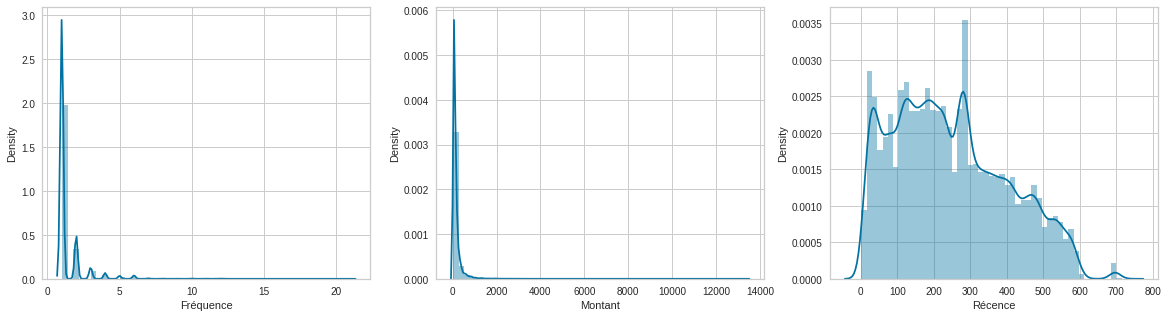

In [37]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data_rfm, ["customer_id"])


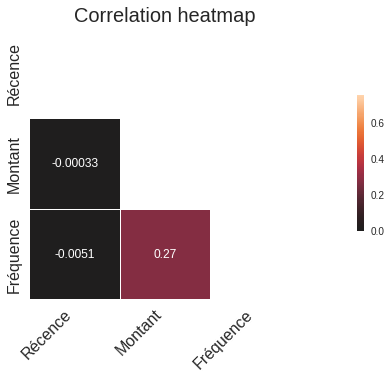

In [38]:
if config["model"]["rfm_raw"]["preparation"]:
    correlation_heatmap(data_rfm, figsize=(20, 5))


In [39]:
if config["model"]["rfm_raw"]["preparation"]:

    model = KMeans(n_clusters=4)

    pipeline, preproc, data_preproc = evaluate(data_rfm, model)


In [40]:
display = None
if config["model"]["rfm_raw"]["preparation"]:
    display = data_preproc.head()
display


,Récence,Montant,Fréquence
0,0.590524,-0.478889,-0.357791
1,0.903891,-0.478889,-0.357791
2,0.988761,-0.478889,-0.357791
3,0.453425,-0.478889,-0.357791
4,0.936533,-0.299444,-0.357791


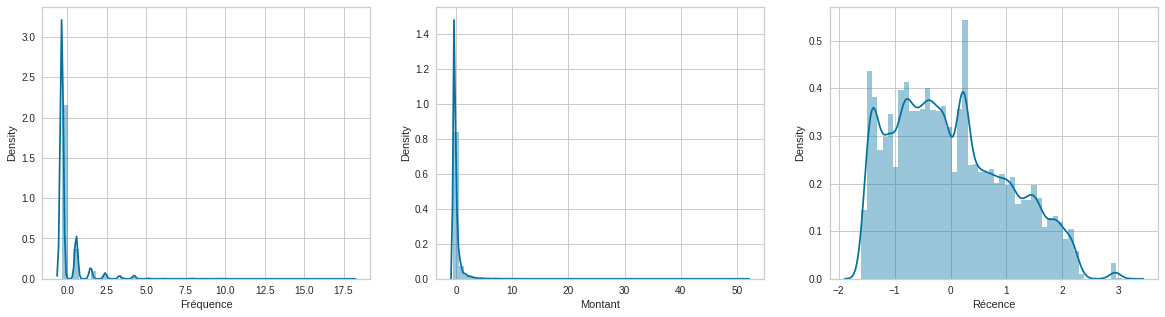

In [41]:
if config["model"]["rfm_raw"]["preparation"]:
    rfm_distplot(data_preproc, ["customer_id"])


***
### 5.1.2 Cluster N analysis

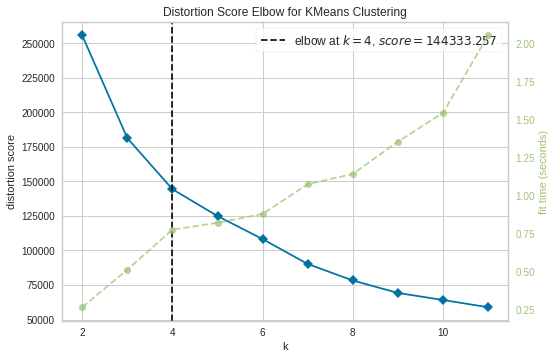

In [42]:
if config["model"]["rfm_raw"]["n_cluster"]:
    elbow(data_preproc.copy(), (2, 12))


In [43]:
if config["model"]["rfm_raw"]["silhouette"]:
    silhouette(data_preproc.copy(), 4)


 Silhouette for n=4
 ![alt text](plots/kmeans_4n.png "Silhouette for n=4")

***
### 5.1.3 Explaination

Récence           Fréquence              Montant                   \
               mean  min  max      mean min max         mean     min      max   
Cluster                                                                         
0        394.290283  264  729  1.213084   1   4   122.891356    2.29    890.0   
1        242.267869    6  699  5.400515   3  21   358.137291   17.50   2000.0   
2        134.403872    1  264  1.205660   1   3   122.294499    0.85    859.9   
3        244.760274    9  699  1.687422   1  10  1523.029315  819.89  13440.0   

                
         count  
Cluster         
0        45156  
1         4659  
2        60284  
3         1606

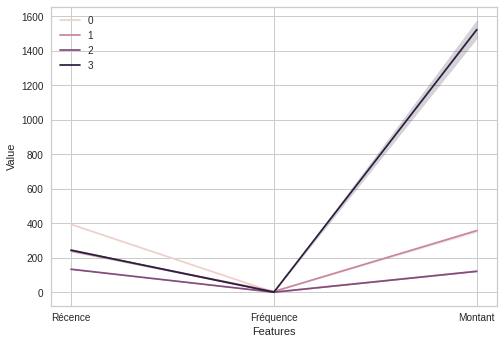

In [44]:
display = None
if config["model"]["rfm_raw"]["explain"]:
    display = explain(data_rfm, data_preproc)
display


In [45]:
if config["model"]["rfm_raw"]["explain"]:
    pred = KMeans(n_clusters=4, random_state=1).fit_predict(data_preproc)


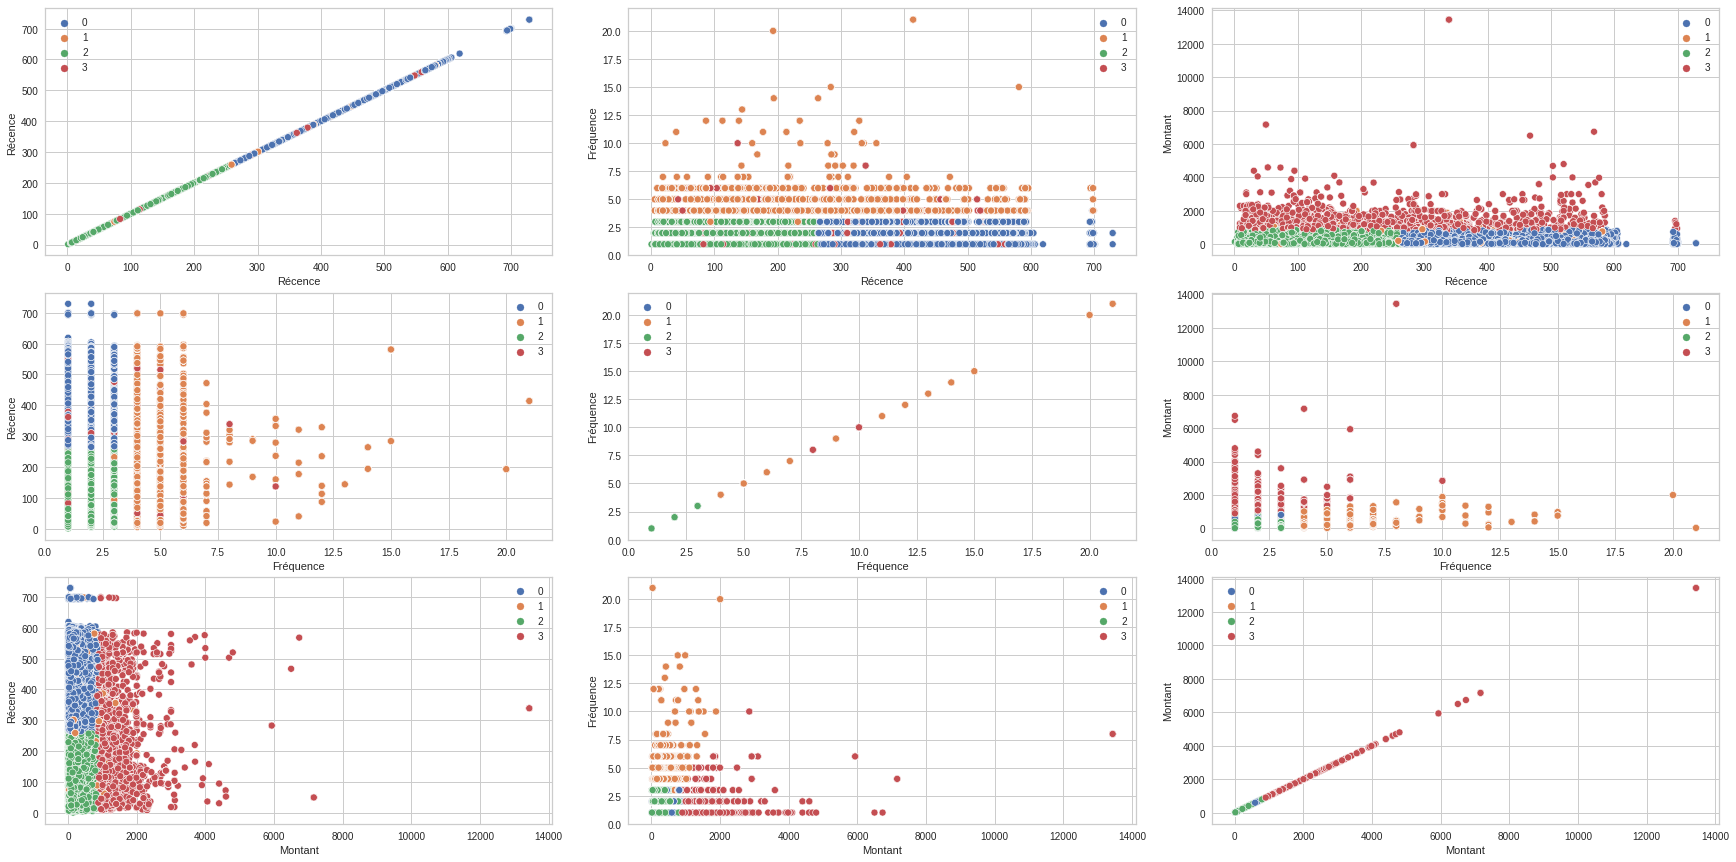

In [46]:
if config["model"]["rfm_raw"]["explain"]:
    plt.subplots(3, 3, figsize=(30, 15))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    plt.subplot(3, 3, 1)
    sns.scatterplot(
        x=data_rfm["Récence"],
        y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 2)
    sns.scatterplot(
        x=data_rfm["Récence"],
        y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 3)
    sns.scatterplot(
        x=data_rfm["Récence"],
        y=data_rfm["Montant"], hue=pred, palette="deep")

    plt.subplot(3, 3, 4)
    sns.scatterplot(
        x=data_rfm["Fréquence"],
        y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 5)
    sns.scatterplot(
        x=data_rfm["Fréquence"],
        y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 6)
    sns.scatterplot(
        x=data_rfm["Fréquence"],
        y=data_rfm["Montant"], hue=pred, palette="deep")

    plt.subplot(3, 3, 7)
    sns.scatterplot(
        x=data_rfm["Montant"],
        y=data_rfm["Récence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 8)
    sns.scatterplot(
        x=data_rfm["Montant"],
        y=data_rfm["Fréquence"], hue=pred, palette="deep")

    plt.subplot(3, 3, 9)
    sns.scatterplot(
        x=data_rfm["Montant"],
        y=data_rfm["Montant"], hue=pred, palette="deep")


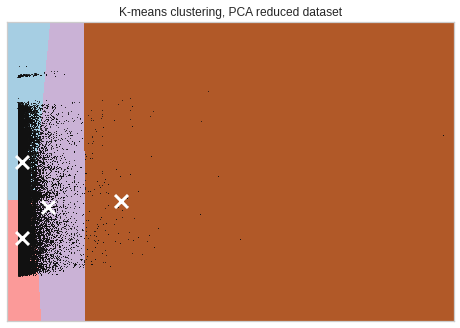

In [47]:
if config["model"]["rfm_raw"]["explain"]:
    display_clusters(data_preproc, 4)


***
### 5.1.4 Persona

In [48]:
if config["model"]["rfm_raw"]["persona"]:
    display


In [49]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc["cluster"] = pred
    data_preproc["order_purchase_timestamp"] = data["order_purchase_timestamp"]
    data_preproc = fe_purchase_timestamp(data_preproc)


In [50]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc.head()


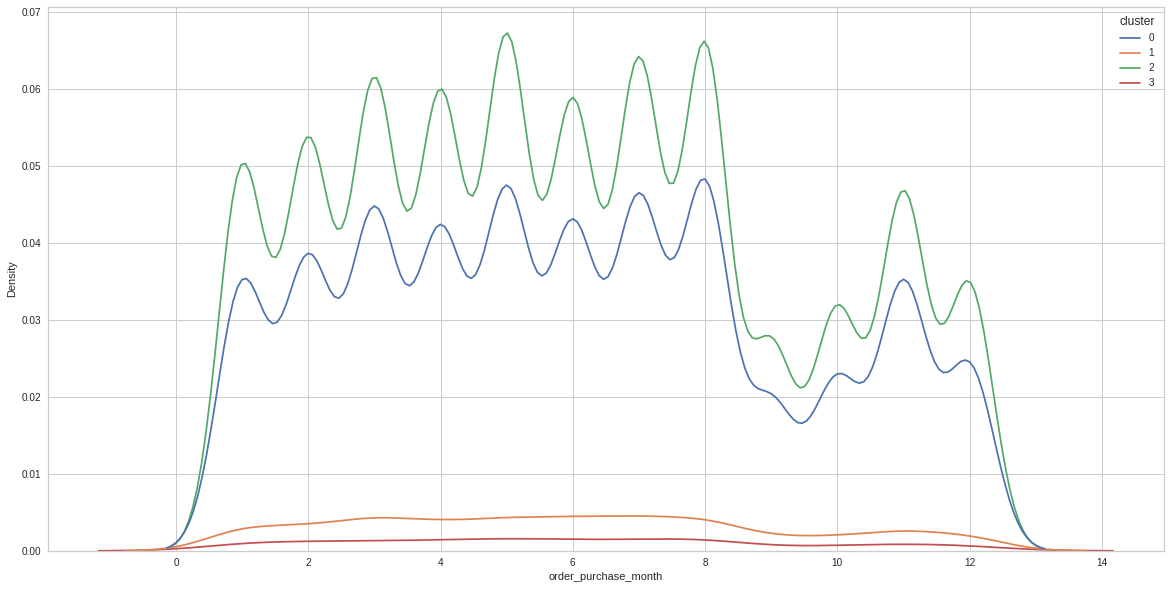

In [51]:
if config["model"]["rfm_raw"]["persona"]:
    plt.figure(figsize=(20, 10))
    sns.kdeplot(
        data=data_preproc,
        x="order_purchase_month", hue="cluster", shade=False, palette="deep")


In [52]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc["product_category_name"] = data["product_category_name"]


In [53]:
if config["model"]["rfm_raw"]["persona"]:
    data_preproc.head()


In [54]:
if config["model"]["rfm_raw"]["persona"]:
    tmp = data_preproc.groupby("cluster").agg({
        "product_category_name": "value_counts"
    })


In [55]:
if config["model"]["rfm_raw"]["persona"]:
    tmp.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 257 entries, (0, 'cama_mesa_banho') to (3, 'moveis_cozinha_area_de_servico_jantar_e_jardim')
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   product_category_name  257 non-null    int64
dtypes: int64(1)
memory usage: 3.2+ KB


In [56]:
if config["model"]["rfm_raw"]["persona"]:
    tmp.head()


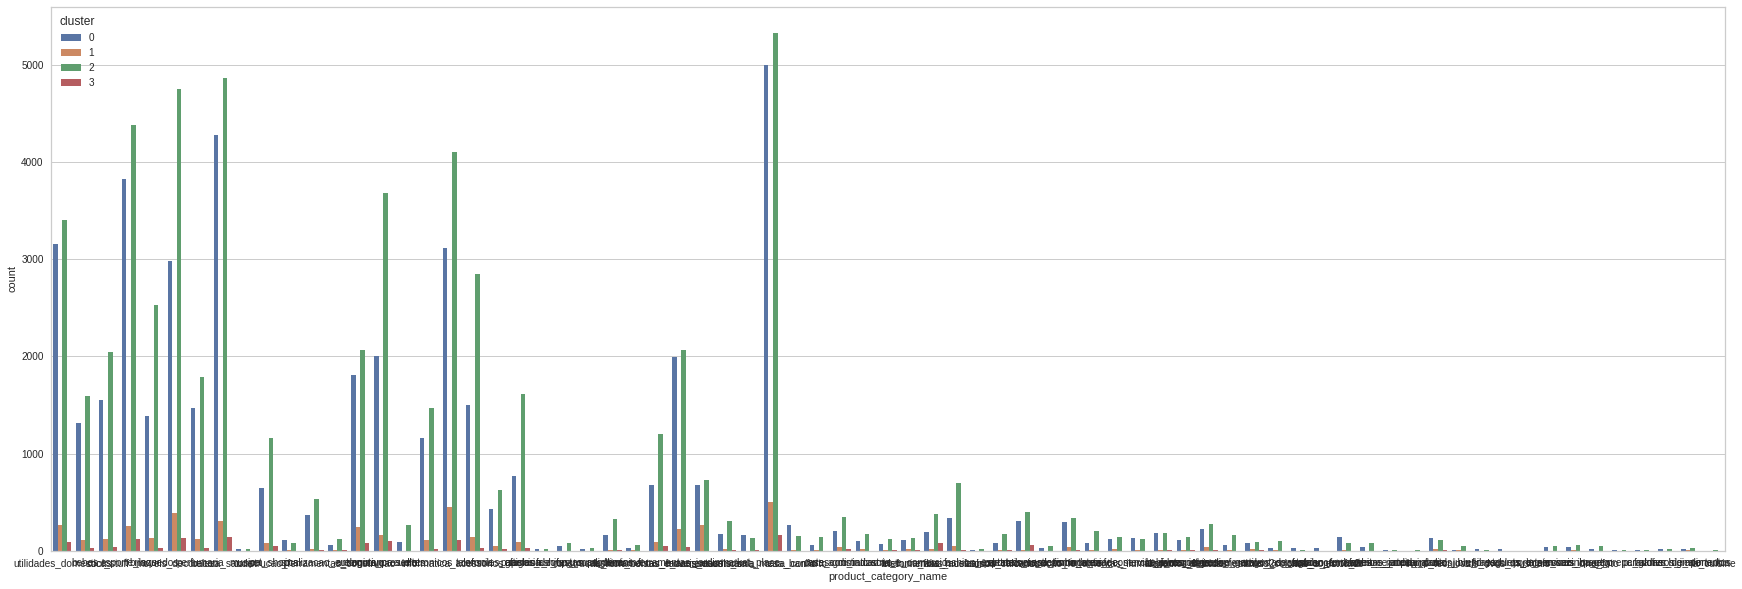

In [57]:
if config["model"]["rfm_raw"]["persona"]:
    plt.figure(figsize=(30, 10))
    sns.countplot(
        data=data_preproc,
        x="product_category_name", hue="cluster", palette="deep")


 #### Cluster 0 - Persona 1 - Anciens

 Dernier achat: il y a plus de 1 an<br>
 Nombre d'achats: 1.2<br>
 Montant: 122€<br>
 Population: 45 156 / 40.42%<br>

 Actions:<br>
 ...


 #### Cluster 1 - Persona 2 - Fidèle

 Dernier achat: il y a 8 mois<br>
 Nombre d'achats: 5.4<br>
 Montant: 358€<br>
 Population: 4 659 / 4.17%<br>


 #### Cluster 2 - Persona 3 - Nouveaux

 Dernier achat: il y a 4 mois<br>
 Nombre d'achats: 1.2<br>
 Montant: 122€<br>
 Population: 60 284 / 53.96%<br>


 #### Cluster 3 - Persona 4 - Fort potentiel

 Dernier achat: il y a 8 mois<br>
 Nombre d'achats: 1.7<br>
 Montant: 819€<br>
 Population: 1 606 / 1.43%<br>

 Actions:<br>
 Client à fort potentiel. Mise en place d'une action de
 fidélisation nécessaire<br>

***
## 5.2 Global

In [58]:
data.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1.0,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366.0,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,credit_card,3.0,37.77,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290.0,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,credit_card,1.0,37.77,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032.0,florianopolis,SC,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38,1,boleto,1.0,44.09,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,02c9e0c05a817d4562ec0e8c90f29dba,8577.0,itaquaquecetuba,SP,b8238c6515192f8129081e17dc57d169,5,NaN,"custo beneficio, simples de usar e rápido",2017-08-17 00:00:00,2017-08-21 12:43:27,1,credit_card,1.0,83.69,1,b00a32a0b42fd65efb58a5822009f629,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-16 13:50:09,75.90,7.79,bebes,58.0,398.0,3.0,238.0,20.0,10.0,15.0,9350,maua,SP


In [59]:
display = None

if config["global"]["do"]:
    global_cols = data.select_dtypes(["int64", "float64"]).columns
    global_cols = global_cols.append(data.loc[
            :,
            [
                "customer_id", "order_id",
                "order_purchase_timestamp", "shipping_limit_date",
                "order_estimated_delivery_date"
            ]].columns)

    global_data = data[global_cols]

    global_data = fe_volume(global_data)
    global_data = fe_price(global_data)
    global_data = fe_frequency(global_data)
    global_data = fe_recency(global_data)
    global_data = fe_shipping_date(global_data)
    global_data = fe_delivery_date(global_data)

    global_data_preproc = preprocess_data(global_data)

    display = global_data_preproc.head()

display


,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,product_volume_cm3,price_min,price_max,price_mean,price_sum,frequency,recency,shipping_limit_year,shipping_limit_month,shipping_limit_day,shipping_limit_hour,order_estimated_delivery_year,order_estimated_delivery_month,order_estimated_delivery_day,order_estimated_delivery_hour
0,-1.091392,-0.024223,-0.088323,-0.715797,-0.590499,-0.283344,-0.496240,-0.719345,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.590524,-1.095879,1.207185,-1.157916,-0.244298,-1.183117,1.195954,0.261557,0.0
1,-1.083997,-0.024223,-0.088323,-0.000042,-0.517486,-0.283344,-0.496240,-0.778985,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.903891,-1.095879,0.585614,0.576697,1.109636,-1.183117,0.556093,1.403438,0.0
2,-1.120665,0.696754,-0.088323,-0.715797,-0.517486,-0.283344,-0.496240,-0.778985,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.988761,-1.095879,0.585614,-0.926634,0.808762,-1.183117,0.556093,-0.081008,0.0
3,1.801291,-0.745200,-0.088323,-0.715797,-0.494003,-0.283344,-0.496240,-0.378002,-0.881661,-0.802921,1.047123,-0.424670,-0.69045,-0.638793,-0.853820,-0.546928,-0.566960,-0.491182,-0.501271,-0.497775,-0.478889,-0.357791,0.453425,-1.095879,1.207185,1.733105,-1.598231,-1.183117,1.515885,-0.309384,0.0
4,-0.906414,0.696754,-0.088323,-0.715797,-0.346862,-0.283344,-0.244687,-0.778351,0.926588,-0.602099,0.462142,-0.494535,-0.62849,-0.489996,-0.682959,-0.546928,-0.523148,-0.238547,-0.251678,-0.245444,-0.299444,-0.357791,0.936533,-1.095879,0.585614,-0.001507,0.056576,-1.183117,0.556093,0.832497,0.0


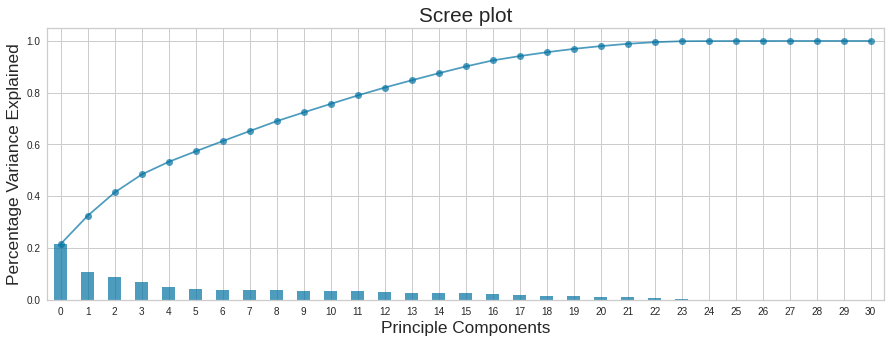

In [60]:
if config["global"]["do"]:
    pca = scree_plot(global_data_preproc)


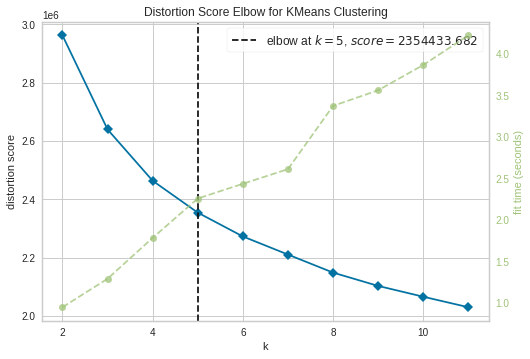

In [61]:
if config["global"]["elbow"]:
    elbow(global_data_preproc)


customer_zip_code_prefix                            review_score  \
                            mean       min       max  count         mean   
Cluster                                                                    
0                       0.161231 -1.164422  2.200622   4015    -0.012371   
1                       0.034869 -1.164490  2.208801  42008     0.039074   
2                       0.211998 -1.163945  2.196022    774    -0.111783   
3                      -0.045875 -1.164524  2.208460  52168     0.028861   
4                       0.013124 -1.164320  2.208120   8954    -0.070683   
5                      -0.000136 -1.163400  2.197896   3786    -0.628084   

                                   payment_sequential                        \
              min       max  count               mean       min         max   
Cluster                                                                       
0       -2.187153  0.696754   4015           0.005928 -0.088323   35.022287   
1       -2.187153  0.696754  42008           0.022840 -0.088323   70.132897   
2       -2.187153  0.696754    774           0.032644 -0.088323   11.615214   
3       -2.187153  0.696754  52168          -0.019524 -0.088323   35.022287   
4       -2.187153  0.696754   8954           0.023214 -0.088323  101.342329   
5       -2.187153  0.696754   3786          -0.052258 -0.088323   11.615214   

               payment_installments                            payment_value  \
         count                 mean       min       max  count          mean   
Cluster                                                                        
0         4015             1.122526 -0.715797  7.515387   4015      1.851215   
1        42008            -0.051626 -0.715797  7.515387  42008     -0.215090   
2          774             1.240046 -0.715797  7.515387    774      6.618117   
3        52168            -0.163188 -0.715797  7.515387  52168     -0.215971   
4         8954             0.413512 -0.715797  7.515387   8954      0.378479   
5         3786             0.399522 -0.715797  7.515387   3786      1.151170   

                                    order_item_id                              \
              min        max  count          mean       min        max  count   
Cluster                                                                         
0       -0.642073  11.391510   4015     -0.175286 -0.283344   5.520705   4015   
1       -0.657790   3.052236  42008     -0.127252 -0.283344   2.618681  42008   
2       -0.472043  50.113442    774     -0.088376 -0.283344   9.873742    774   
3       -0.657790   2.921630  52168     -0.140434 -0.283344   2.618681  52168   
4       -0.657790   9.913117   8954     -0.100225 -0.283344   6.971717   8954   
5       -0.649393  11.391510   3786      3.787999 -0.283344  28.736901   3786   

            price                             freight_value            \
             mean       min        max  count          mean       min   
Cluster                                                                 
0        2.487271 -0.474268   6.955607   4015      0.742668 -1.268160   
1       -0.196313 -0.648015   1.635247  42008     -0.212938 -1.271967   
2        8.099568 -0.003051  36.242247    774      3.137728 -0.511875   
3       -0.197958 -0.655905   1.552510  52168     -0.164379 -1.271967   
4        0.368032 -0.559196   5.092659   8954      1.422015 -1.270698   
5       -0.258067 -0.653987   1.870307   3786     -0.164471 -1.271332   

                          product_name_lenght                             \
               max  count                mean       min       max  count   
Cluster                                                                    
0        12.528975   4015           -0.047395 -3.393117  1.529337   4015   
1         6.965327  42008           -0.018678 -4.397699  2.333003  42008   
2        24.720272    774            0.134933 -3.493575  1.428879    774   
3         6.464732  52168            0.023479 

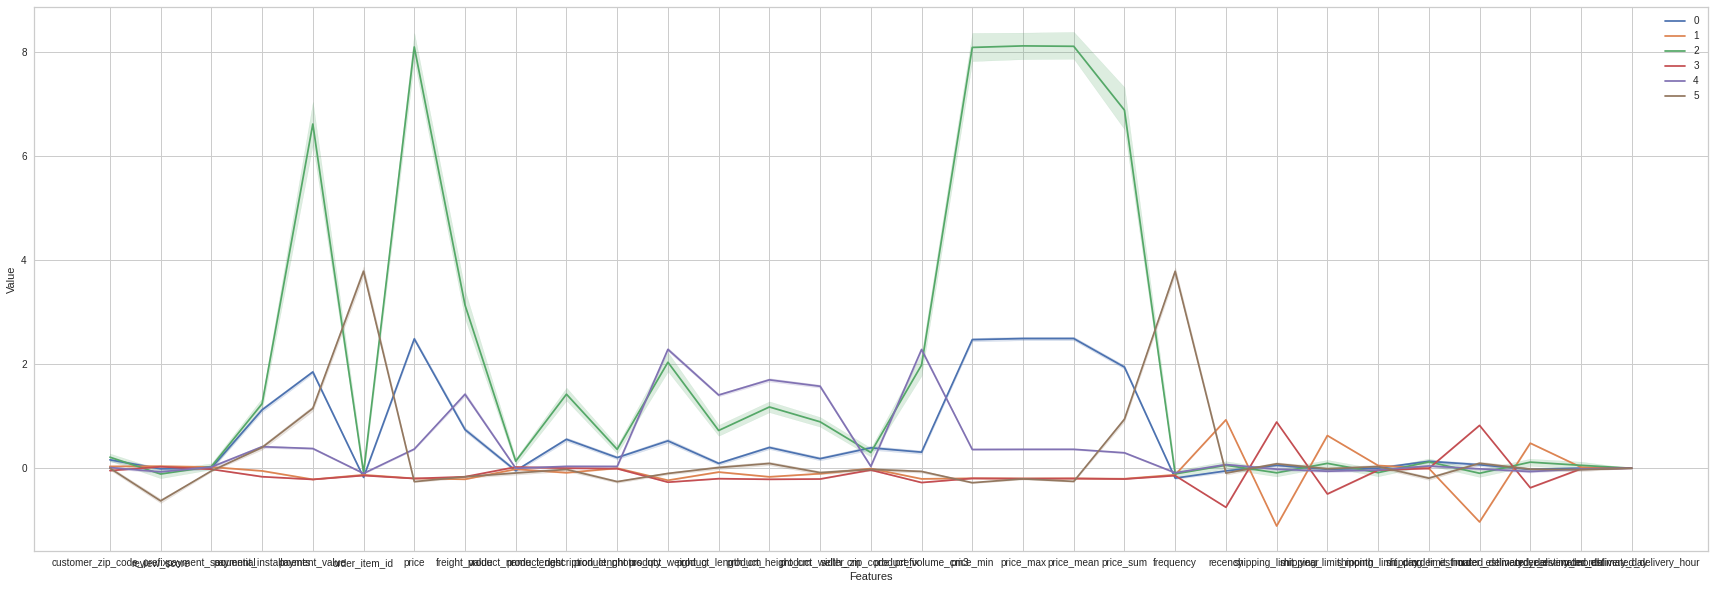

In [62]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 6)
    display = explain_data
display


In [63]:
if config["global"]["do"]:
    global_data_preproc.drop(
        columns=[
            "customer_zip_code_prefix", "review_score",
            "payment_installments", "payment_value",
            "order_item_id", "product_name_lenght",
            "product_description_lenght", "product_photos_qty",
            "product_length_cm", "product_height_cm",
            "product_width_cm", "seller_zip_code_prefix",
            "shipping_limit_year", "shipping_limit_month",
            "shipping_limit_day", "shipping_limit_hour",
            "order_estimated_delivery_year", "order_estimated_delivery_month",
            "order_estimated_delivery_day", "order_estimated_delivery_hour",
            "payment_sequential", "price_min", "price_max", "price_mean"
            ], inplace=True)


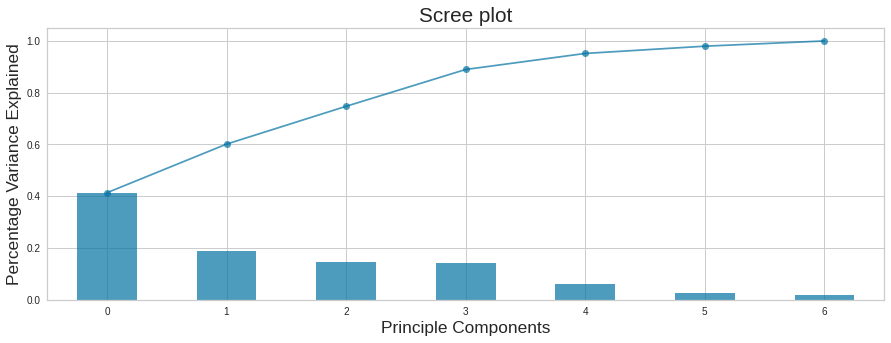

In [64]:
if config["global"]["do"]:
    pca = scree_plot(global_data_preproc)


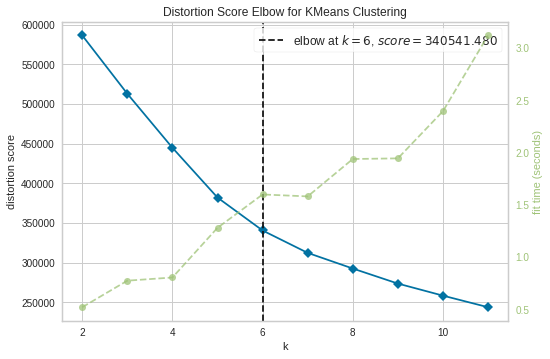

In [65]:
if config["global"]["elbow"]:
    elbow(global_data_preproc)


price                             freight_value            \
             mean       min        max  count          mean       min   
Cluster                                                                 
0       -0.202817 -0.653987   1.032528    340     -0.016072 -1.267526   
1       -0.206754 -0.648015   1.744832  31477     -0.299164 -1.270698   
2        0.859883 -0.531855   5.667982   3321      2.327580 -1.269429   
3        9.909458  2.242897  36.242247    410      2.528165 -0.511240   
4        0.220762 -0.633221   2.626993   5302      1.608808 -0.052520   
5       -0.204550 -0.655905   1.854417  31320     -0.261653 -1.271967   
6        8.544593  8.544593   8.544593      8      0.504543  0.504543   
7       -0.321585 -0.641385   1.366763   6897     -0.272005 -1.271967   
8        2.759647 -0.367751  12.150383    555      7.478979  2.174462   
9       -0.189031 -0.644673   2.035452  20914     -0.234251 -1.271967   
10       3.105766 -0.474268   7.344580   2680      0.498377 -1.268160   
11       0.134698 -0.579196   2.243390   8481      0.189306 -1.271332   

                          product_weight_g                              \
               max  count             mean       min        max  count   
Cluster                                                                  
0         4.346879    340         0.185666 -0.518001   4.615202    340   
1         1.416273  31477        -0.339103 -0.557467   1.388617  31477   
2         8.994355   3321         3.334639 -0.544667  10.221727   3321   
3        18.869845    410         1.532249 -0.544667   7.441797    410   
4        10.511367   5302         0.292990 -0.557467   3.735224   5302   
5         1.201188  31320        -0.335403 -0.557467   2.168597  31320   
6         0.504543      8        -0.358005 -0.358005  -0.358005      8   
7         3.156618   6897        -0.246523 -0.544667   3.012043   6897   
8        24.720272    555         5.712174 -0.544667   7.441797    555   
9         2.172558  20914        -0.295767 -0.544667   2.168597  20914   
10        5.702737   2680         0.172826 -0.544667   5.628510   2680   
11        2.763248   8481         1.428490 -0.528668   6.028500   8481   

        product_volume_cm3                              price_sum             \
                      mean       min        max  count       mean        min   
Cluster                                                                        
0                 0.216541 -0.636444   4.523802    340   3.205619  -0.471815   
1                -0.300797 -0.636444   1.759446  31477  -0.234593  -0.587158   
2                 3.011578 -0.636444  10.175052   3321   0.756600  -0.504295   
3                 1.183153 -0.636444  11.381083    410   8.128438   4.250596   
4                 0.055343 -0.636444   3.247304   5302   0.108328  -0.576605   
5                -0.320367 -0.644316   2.086753  31320  -0.229776  -0.592787   
6                -0.476256 -0.476256  -0.476256      8  51.935921  51.935921   
7                -0.185363 -0.636444   3.932339   6897   0.389435  -0.527708   
8                 6.775599 -0.578085  12.021835    555   2.192359  -0.387232   
9                -0.226815 -0.636444   2.368024  20914  -0.213861  -0.584774   
10                0.035139 -0.639182   4.510881   2680   2.505670   1.006430   
11                1.275759 -0.636444   5.911200   8481   0.060200  -0.538066   

                           frequency                               recency  \
               max  count       mean       min        max  count      mean   
Cluster                                                                      
0        11.519676    340  10.083395  4.222858  17.964806    340 -0.049134   
1         2.323640  31477  -0.225045 -0.357791   0.558339  31477  0.100833   
2         7.201614   3321   0.016274 -0.357791   6.971248   3321  0.062035   
3        27.389704    410  -0.076249 -0.357791   4.222858    410 -0.048854   
4         3.820607   5302  -0.212130 -0.357791   2.390598 

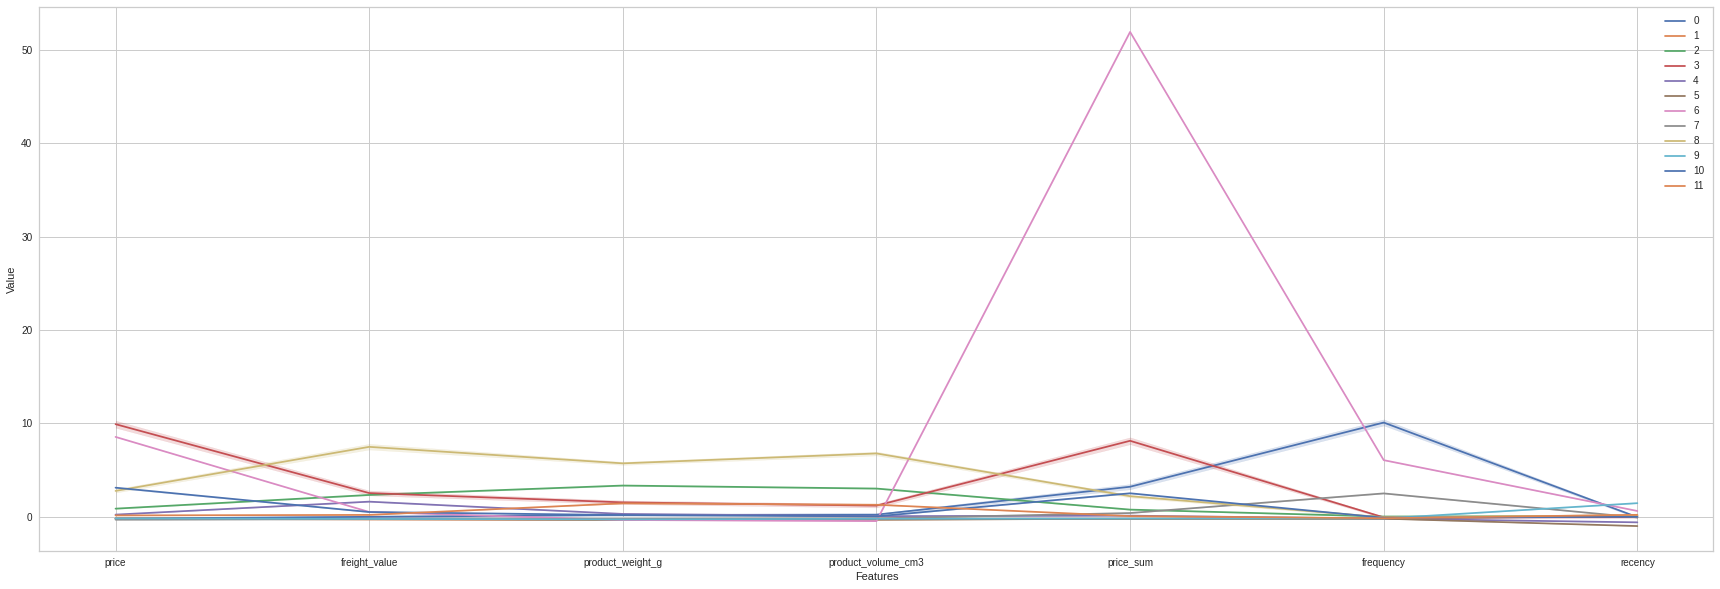

In [66]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 12)
    display = explain_data
display


price                             freight_value            \
             mean       min        max  count          mean       min   
Cluster                                                                 
0       -0.199447 -0.648015   1.876334  35783     -0.249929 -1.271967   
1        2.682090 -0.367751  12.150383    608      7.286855  1.328716   
2        0.160929 -0.606318   2.097368  11607      0.513794 -1.271332   
3       -0.198130 -0.655905   1.749763  49044     -0.212944 -1.271967   
4        3.017903 -0.474268   7.344580   2847      0.563583 -1.268160   
5        0.745778 -0.531855   5.667982   3962      2.059993 -1.269429   
6       -0.202817 -0.653987   1.032528    340     -0.016072 -1.267526   
7        9.872733  2.242897  36.242247    415      2.519453 -0.511240   
8        8.544593  8.544593   8.544593      8      0.504543  0.504543   
9       -0.322670 -0.643796   1.366763   7091     -0.256313 -1.271967   

                          product_weight_g                              \
               max  count             mean       min        max  count   
Cluster                                                                  
0         3.795527  35783        -0.317902 -0.544667   2.168597  35783   
1        24.720272    608         5.588549 -0.544667   7.441797    608   
2         6.837165  11607         1.123404 -0.544667   6.028500  11607   
3         4.061369  49044        -0.346731 -0.557467   2.055267  49044   
4         6.965327   2847         0.157626 -0.544667   5.628510   2847   
5        10.511367   3962         3.170828 -0.544667  10.221727   3962   
6         4.346879    340         0.185666 -0.518001   4.615202    340   
7        18.869845    415         1.520169 -0.544667   7.441797    415   
8         0.504543      8        -0.358005 -0.358005  -0.358005      8   
9         3.559505   7091        -0.248110 -0.544667   3.012043   7091   

        product_volume_cm3                              price_sum             \
                      mean       min        max  count       mean        min   
Cluster                                                                        
0                -0.251204 -0.636444   2.726821  35783  -0.224405  -0.587158   
1                 6.551531 -0.578085  12.021835    608   2.118409  -0.387232   
2                 0.910576 -0.636444   4.140446  11607   0.064449  -0.557414   
3                -0.330138 -0.644316   2.086753  49044  -0.226591  -0.592787   
4                 0.028138 -0.639182   5.413308   2847   2.426342   0.849694   
5                 2.860090 -0.636444  10.147583   3962   0.664008  -0.504295   
6                 0.216541 -0.636444   4.523802    340   3.205619  -0.471815   
7                 1.176785 -0.636444  11.381083    415   8.087970   4.250596   
8                -0.476256 -0.476256  -0.476256      8  51.935921  51.935921   
9                -0.189287 -0.636444   3.932339   7091   0.381646  -0.560228   

                           frequency                               recency  \
               max  count       mean       min        max  count      mean   
Cluster                                                                      
0         2.365071  35783  -0.203742 -0.357791   1.474468  35783  1.014825   
1         8.542588    608  -0.083555 -0.357791   5.138988    608  0.126013   
2         2.452625  11607  -0.202854 -0.357791   2.390598  11607 -0.008485   
3         2.402985  49044  -0.223092 -0.357791   1.474468  49044 -0.724642   
4        10.814755   2847  -0.125461 -0.357791   4.222858   2847 -0.032434   
5         7.201614   3962   0.020037 -0.357791   6.971248   3962  0.044223   
6        11.519676    340  10.083395  4.222858  17.964806    340 -0.049134   
7        27.389704    415  -0.079641 -0.357791   4.222858    415 -0.049016   
8        51.935921      8   6.055118  6.055118   6.055118      8  0.610109   
9         4.778261   7091   2.463852  0.558339   6.055118   7091 -0.113238   

                                    
      

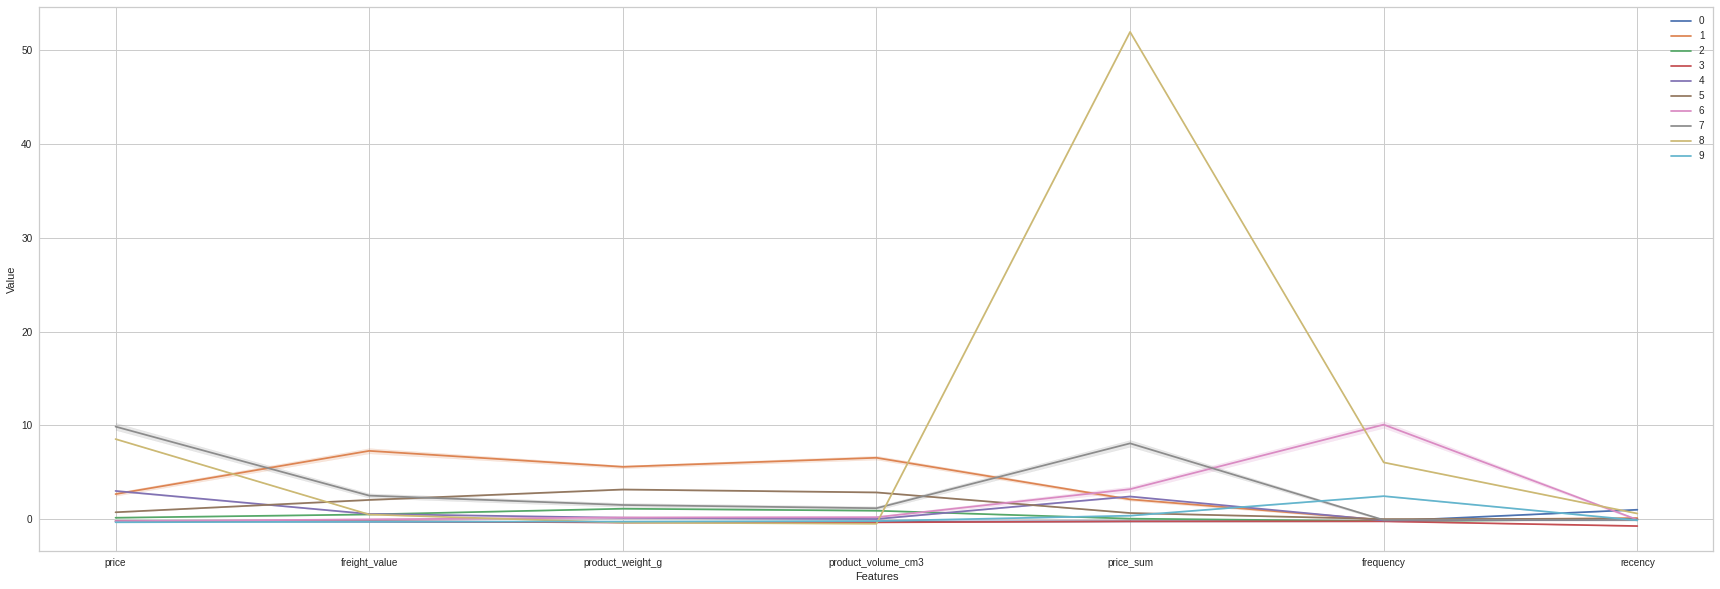

In [67]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 10)
    display = explain_data
display


price                             freight_value            \
              mean       min        max  count          mean       min   
Cluster                                                                  
0         3.252340 -0.474268   8.243233   2752      0.638731 -1.268160   
1        -0.203670 -0.655905   1.854417  50455     -0.216337 -1.271967   
2        -0.199415 -0.648015   2.035452  37200     -0.251206 -1.271967   
3         0.719369 -0.531855   5.404922   3958      2.049558 -1.269429   
4        -0.302460 -0.653987   1.256630   4439     -0.233284 -1.270698   
5         0.169503 -0.619468   2.243390  11961      0.510870 -1.271332   
6         2.870045 -0.367751  12.150383    625      7.226986  1.328716   
7        10.851227  3.339297  36.242247    315      2.534539 -0.511240   

                          product_weight_g                              \
               max  count             mean       min        max  count   
Cluster                                                                  
0         7.085242   2752         0.211866 -0.544667   7.441797   2752   
1         3.920517  50455        -0.348099 -0.557467   2.055267  50455   
2         3.795527  37200        -0.318093 -0.544667   2.168597  37200   
3        10.511367   3958         3.174746 -0.544667  10.221727   3958   
4         4.346879   4439        -0.174249 -0.544667   4.615202   4439   
5         6.837165  11961         1.092893 -0.544667   5.355183  11961   
6        24.720272    625         5.584900 -0.544667   7.441797    625   
7        18.869845    315         1.455680 -0.544667   7.441797    315   

        product_volume_cm3                             price_sum            \
                      mean       min        max  count      mean       min   
Cluster                                                                      
0                 0.071569 -0.639182   5.413308   2752  2.615926  0.924349   
1                -0.330040 -0.644316   1.915612  50455 -0.215406 -0.592787   
2                -0.251316 -0.636444   2.726821  37200 -0.211199 -0.587158   
3                 2.865567 -0.636444  10.147583   3958  0.633102 -0.504295   
4                -0.131592 -0.636444   4.523802   4439  0.792253 -0.527708   
5                 0.889415 -0.636444   4.140446  11961  0.079822 -0.557414   
6                 6.480867 -0.578085  12.021835    625  2.243509 -0.387232   
7                 1.135038 -0.636444  11.381083    315  9.988332  5.067500   

                          frequency                               recency  \
               max  count      mean       min        max  count      mean   
Cluster                                                                     
0        11.519676   2752 -0.137081 -0.357791   4.222858   2752 -0.046699   
1         2.402985  50455 -0.161347 -0.357791   1.474468  50455 -0.730742   
2         3.378971  37200 -0.155996 -0.357791   2.390598  37200  0.995535   
3         7.201614   3958 -0.002496 -0.357791   6.971248   3958  0.046723   
4        10.543104   4439  3.729811  1.474468  17.964806   4439 -0.007465   
5         2.452625  11961 -0.182776 -0.357791   2.390598  11961 -0.022854   
6         8.542588    625 -0.091014 -0.357791   5.138988    625  0.118039   
7        51.935921    315  0.055194 -0.357791   6.055118    315  0.038069   

                                    
              min       max  count  
Cluster                             
0       -1.557349  2.960364   2752  
1       -1.570406  0.172700  50455  
2        0.074773  3.156219  37200  
3       -1.570406  2.960364   3958  
4       -1.563877  2.960364   4439  
5       -1.596519  2.966893  11961  
6       -1.544292  2.953836    625  
7       -1.544292  2.209588    315

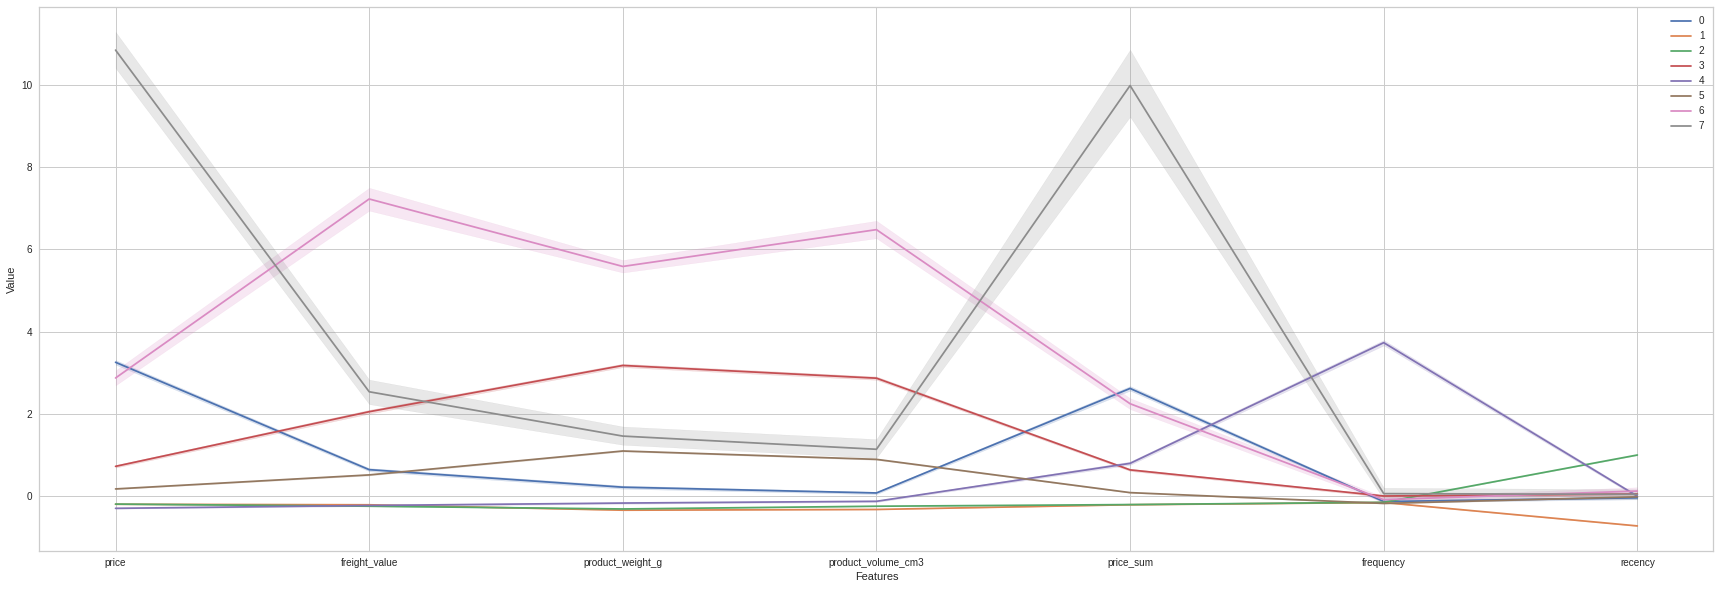

In [68]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 8)
    display = explain_data
display


price                             freight_value            \
             mean       min        max  count          mean       min   
Cluster                                                                 
0        0.371657 -0.606318   3.777089  11357      0.897983 -1.269429   
1       -0.154335 -0.655905   3.522852  53416     -0.180957 -1.271967   
2        6.070088 -0.222770  36.242247   1386      1.275212 -1.268160   
3       -0.155898 -0.648015   3.498195  39393     -0.233108 -1.271967   
4       -0.274276 -0.653987   2.626938   4545     -0.219204 -1.270698   
5        1.864296 -0.436735  14.127958   1608      4.900035 -0.456676   

                          product_weight_g                              \
               max  count             mean       min        max  count   
Cluster                                                                  
0         7.196274  11357         1.751514 -0.544667  10.221727  11357   
1         4.429994  53416        -0.309772 -0.557467   2.321927  53416   
2        18.869845   1386         0.786120 -0.544667   7.441797   1386   
3         3.795527  39393        -0.283698 -0.544667   2.415258  39393   
4         4.221889   4545        -0.164505 -0.544667   4.615202   4545   
5        24.720272   1608         4.657147 -0.544667   7.441797   1608   

        product_volume_cm3                             price_sum            \
                      mean       min        max  count      mean       min   
Cluster                                                                      
0                 1.437149 -0.636444  10.147583  11357  0.265066 -0.557414   
1                -0.296766 -0.644316   2.343465  53416 -0.178723 -0.592787   
2                 0.531373 -0.636444   8.801131   1386  5.229251  2.096939   
3                -0.213167 -0.639182   3.145774  39393 -0.179074 -0.587158   
4                -0.124153 -0.636444   4.523802   4545  0.853545 -0.527708   
5                 4.823014 -0.636444  12.021835   1608  1.531994 -0.436442   

                          frequency                               recency  \
               max  count      mean       min        max  count      mean   
Cluster                                                                     
0         5.140983  11357 -0.138056 -0.357791   3.306728  11357  0.016911   
1         4.356911  53416 -0.164810 -0.357791   1.474468  53416 -0.728974   
2        51.935921   1386 -0.064313 -0.357791   6.055118   1386 -0.006343   
3         3.703309  39393 -0.159347 -0.357791   2.390598  39393  0.981397   
4        10.543104   4545  3.689910  0.558339  17.964806   4545 -0.016090   
5         9.953292   1608 -0.020510 -0.357791   7.887377   1608  0.104829   

                                    
              min       max  count  
Cluster                             
0       -1.596519  2.966893  11357  
1       -1.570406  0.211871  53416  
2       -1.544292  2.960364   1386  
3        0.009488  3.156219  39393  
4       -1.563877  2.960364   4545  
5       -1.563877  2.960364   1608

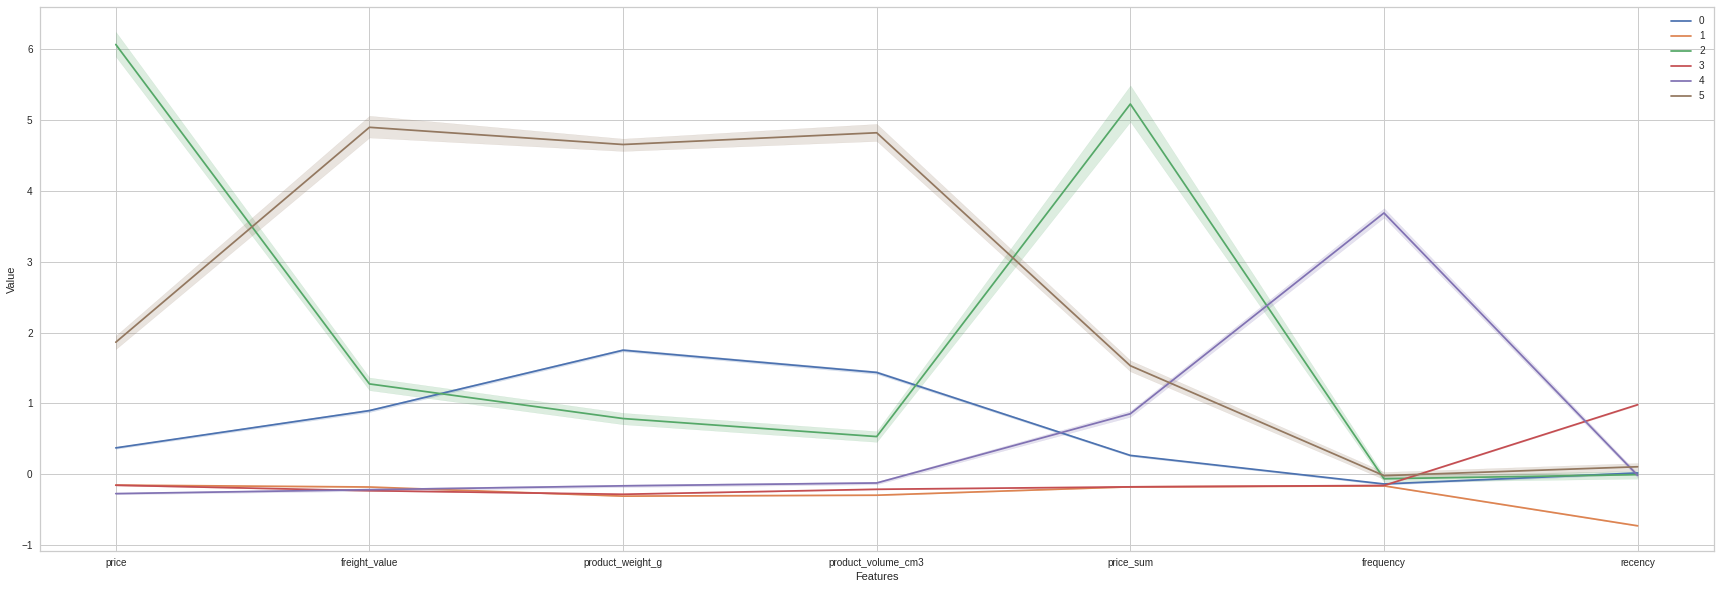

In [69]:
display = None
if config["global"]["explain_plot"]:
    explain_data = explain_global(global_data, global_data_preproc, 6)
    display = explain_data
display


In [70]:
if config["global"]["do"]:
    pred = KMeans(
        n_clusters=6,
        random_state=1
        ).fit_predict(global_data_preproc)


 We can deduce:<br>

 Clusters 1 and 3 -> Losts<br>
 Are very similar and are the leasts interesting clusters.<br>
 Maybe low purchasing power customer ?

 Cluster 4 -> Loyals<br>
 Represent the clients who bought the more often.<br>
 Middle class customer ?<br>
 From town ?<br>

 Cluster 5 -> Big articles<br>
 Represents customers who bought heavy,
  big articles from far away sellers.<br>
 Maybe for particular occasion, like a relocation ?<br>
 Maybe customer from the countryside ?

 Cluster 2 -> Best<br>
 Represents customers who ave spent the most.<br>
 The bought articles are small, light, most certainyl commonly bought.<br>
 Big purchasing power ?<br>
 From city ?<br>

 Cluster 0 -> Potential<br>
 Represents customers who ave not spent much but on <br>
 bigger and heavier articlesthan average with average freight<br>
 so most commonly boughts articles.<br>
 Maybe a lak of peticular articles ?

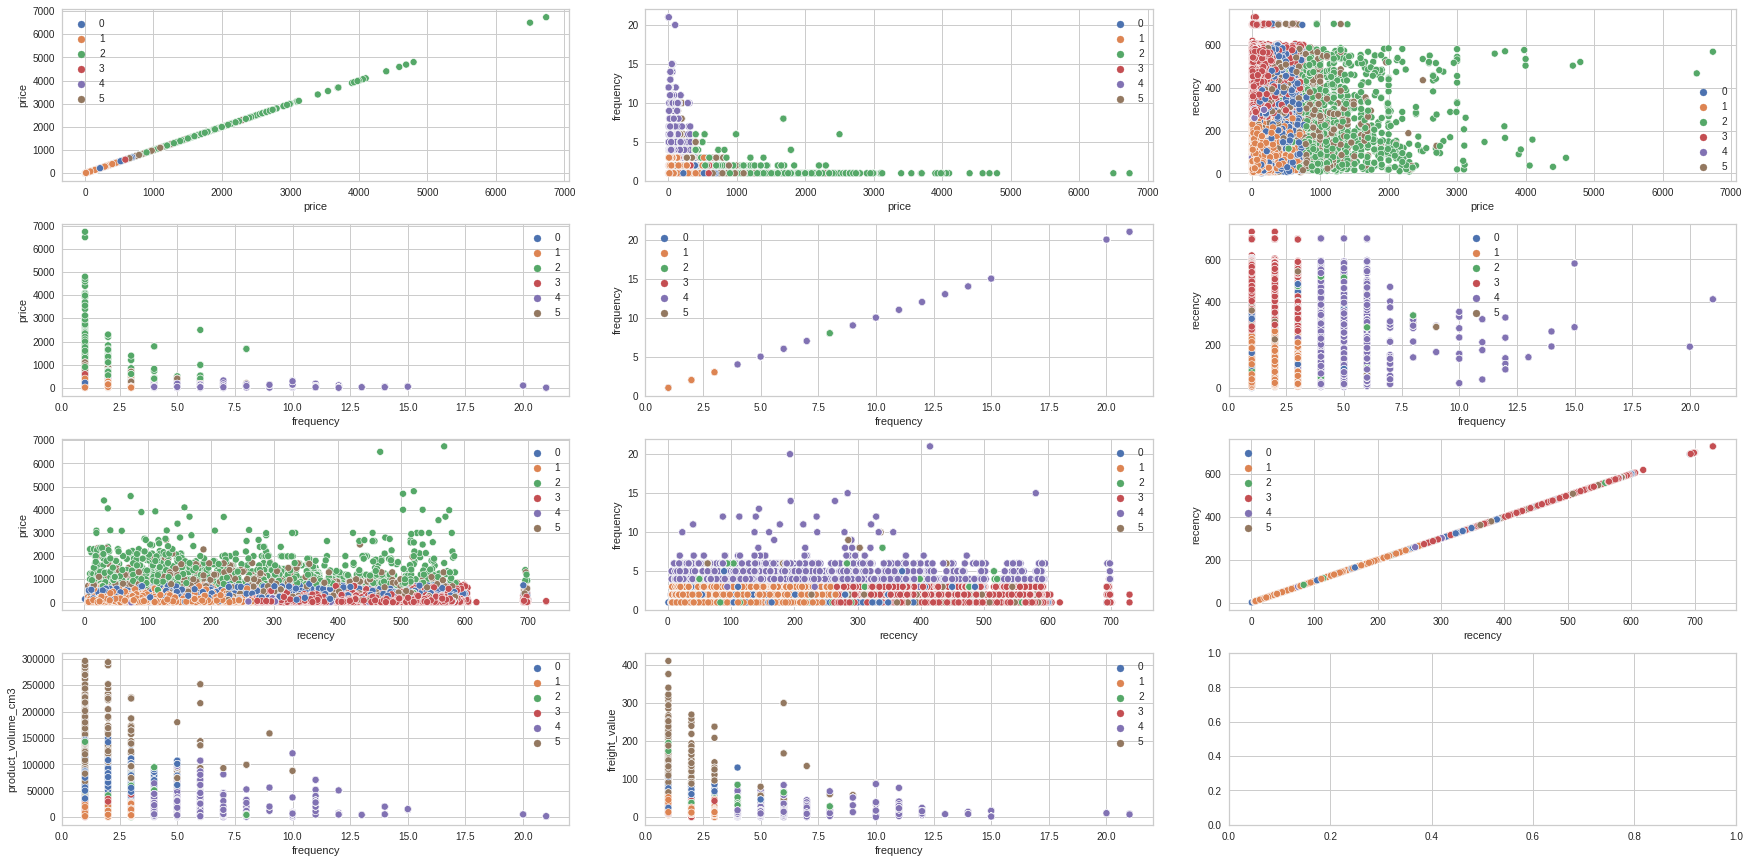

In [71]:
if config["global"]["features_plot"]:
    global_data["frequency"]

    nb_rows = 4

    plt.subplots(nb_rows, 3, figsize=(30, 15))
    plt.subplots_adjust(wspace=0.15, hspace=0.25)

    plt.subplot(nb_rows, 3, 1)
    sns.scatterplot(
        x=global_data["price"],
        y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 2)
    sns.scatterplot(
        x=global_data["price"],
        y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 3)
    sns.scatterplot(
        x=global_data["price"],
        y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 4)
    sns.scatterplot(
        x=global_data["frequency"],
        y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 5)
    sns.scatterplot(
        x=global_data["frequency"],
        y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 6)
    sns.scatterplot(
        x=global_data["frequency"],
        y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 7)
    sns.scatterplot(
        x=global_data["recency"],
        y=global_data["price"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 8)
    sns.scatterplot(
        x=global_data["recency"],
        y=global_data["frequency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 9)
    sns.scatterplot(
        x=global_data["recency"],
        y=global_data["recency"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 10)
    sns.scatterplot(
        x=global_data["frequency"],
        y=global_data["product_volume_cm3"], hue=pred, palette="deep")

    plt.subplot(nb_rows, 3, 11)
    sns.scatterplot(
        x=global_data["frequency"],
        y=global_data["freight_value"], hue=pred, palette="deep")


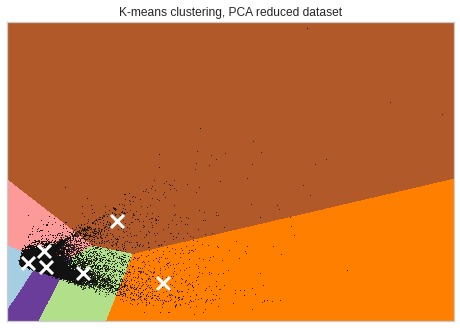

In [72]:
if config["global"]["cluster_plot"]:
    display_clusters(global_data_preproc, 6)


***
## 5.3 Geospatial analysis

### 5.3.1 Geoloc dataset preprocessing

In [73]:
re_write = False
if config["geo"]["preproc"]:
    geo_data = gpd.read_file("data/olist_geolocation_dataset.csv")

    geo_data["geolocation_lat"] = geo_data["geolocation_lat"].astype("float64")
    geo_data["geolocation_lng"] = geo_data["geolocation_lng"].astype("float64")

    geo_data["geolocation_lat"] = geo_data["geolocation_lat"].where(
        lambda x: x < 10, np.nan
        )
    geo_data.dropna(subset=["geolocation_lat"], inplace=True)

    geo_data = gpd.GeoDataFrame(
        geo_data,
        geometry=gpd.points_from_xy(
            geo_data["geolocation_lng"],
            geo_data["geolocation_lat"]))
    geo_data.to_file("data/olist_geolocation_dataset.json", driver="GeoJSON")


***
### 5.3.2 Base geoloc arrangment

In [74]:
if config["geo"]["arange"]:
    geo_data = gpd.read_file("data/olist_geolocation_dataset.json")


In [75]:
if config["geo"]["arange"]:
    geo_data.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000137 entries, 0 to 1000136
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   geolocation_zip_code_prefix  1000137 non-null  object  
 1   geolocation_lat              1000137 non-null  float64 
 2   geolocation_lng              1000137 non-null  float64 
 3   geolocation_city             1000137 non-null  object  
 4   geolocation_state            1000137 non-null  object  
 5   geometry                     1000137 non-null  geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 45.8+ MB


In [76]:
if config["geo"]["arange"]:
    geo_data["geolocation_zip_code_prefix"] = geo_data[
        "geolocation_zip_code_prefix"
        ].astype("int64")


In [77]:
if config["geo"]["arange"]:
    geo_data.head()


In [78]:
if config["geo"]["arange"]:
    brazil_geo = gpd.read_file("data/brazil_geo.json")


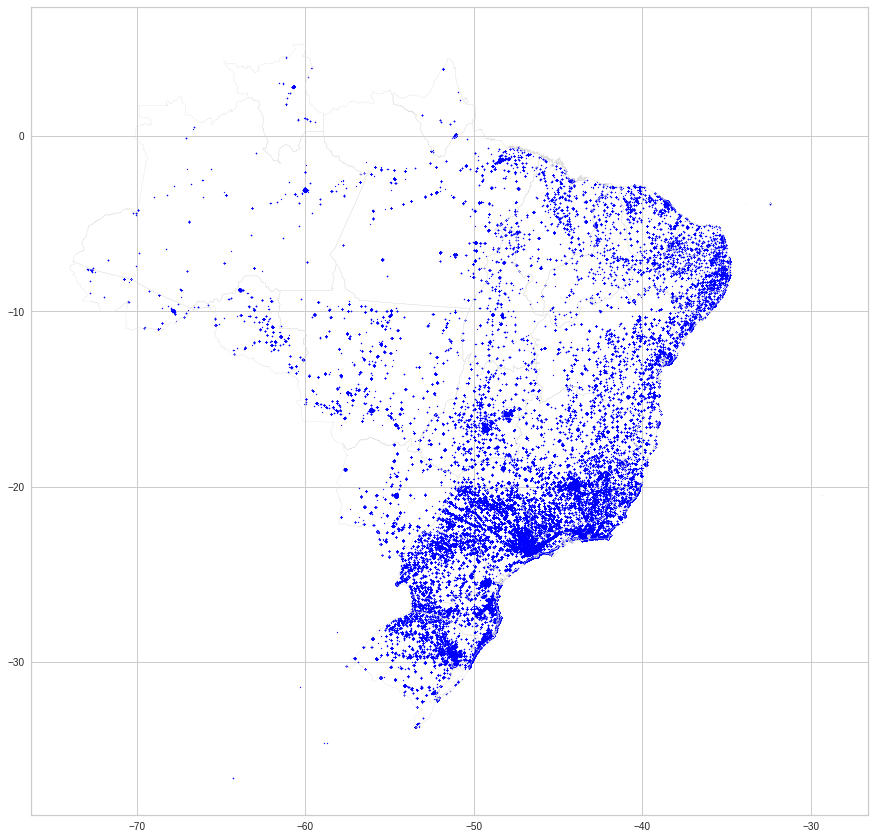

In [79]:
if config["geo"]["arange"]:
    ax = brazil_geo.plot(
        figsize=(15, 15),
        color="none",
        edgecolor="gainsboro",
        zorder=3
        )
    geo_data.plot(color="blue", markersize=1, ax=ax)


***
### 5.3.2 Clustered geoloc points

In [80]:
if config["geo"]["all"]:
    global_data.loc[:, "Cluster"] = pred


In [81]:
if config["geo"]["all"]:
    global_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 111705 entries, 0 to 111704
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   customer_zip_code_prefix        107697 non-null  float64       
 1   review_score                    111705 non-null  int64         
 2   payment_sequential              111705 non-null  int64         
 3   payment_installments            111702 non-null  float64       
 4   payment_value                   111705 non-null  float64       
 5   order_item_id                   111705 non-null  int64         
 6   price                           111705 non-null  float64       
 7   freight_value                   111323 non-null  float64       
 8   product_name_lenght             110116 non-null  float64       
 9   product_description_lenght      110116 non-null  float64       
 10  product_photos_qty              110116 non-null  float64

In [82]:
if config["geo"]["all"]:
    global_data.dropna(inplace=True)


In [83]:
if config["geo"]["all"]:
    global_data.loc[:, "customer_zip_code_prefix"] = global_data[
        "customer_zip_code_prefix"
        ].astype("int64")


In [84]:
if config["geo"]["all"]:
    global_data.head()


In [85]:
if config["geo"]["all"]:
    global_data["customer_zip_code_prefix"].value_counts().count()


In [86]:
if config["geo"]["all"]:
    by_customer_zip_code_prefix = global_data.groupby("Cluster")


In [87]:
if config["geo"]["all"]:
    by_customer_zip_code_prefix.head()


In [88]:
if config["geo"]["all"]:
    global_data_cleaned = global_data.loc[
        :,
        [
            "customer_zip_code_prefix", "seller_zip_code_prefix",
            "customer_id", "Cluster"
        ]]
    geo_merged = geo_data.merge(
        global_data_cleaned,
        left_on="geolocation_zip_code_prefix",
        right_on="customer_zip_code_prefix")


In [89]:
if config["geo"]["all"]:
    geo_merged.head()


In [90]:
if config["geo"]["all"]:
    geo_merged.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 16128653 entries, 0 to 16128652
Data columns (total 10 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   geolocation_zip_code_prefix  int64   
 1   geolocation_lat              float64 
 2   geolocation_lng              float64 
 3   geolocation_city             object  
 4   geolocation_state            object  
 5   geometry                     geometry
 6   customer_zip_code_prefix     int64   
 7   seller_zip_code_prefix       int64   
 8   customer_id                  object  
 9   Cluster                      int32   
dtypes: float64(2), geometry(1), int32(1), int64(3), object(3)
memory usage: 1.3+ GB


In [91]:
if config["geo"]["all"]:
    geo_merged.drop_duplicates(
        subset=["geolocation_lng", "geolocation_lat"], inplace=True)


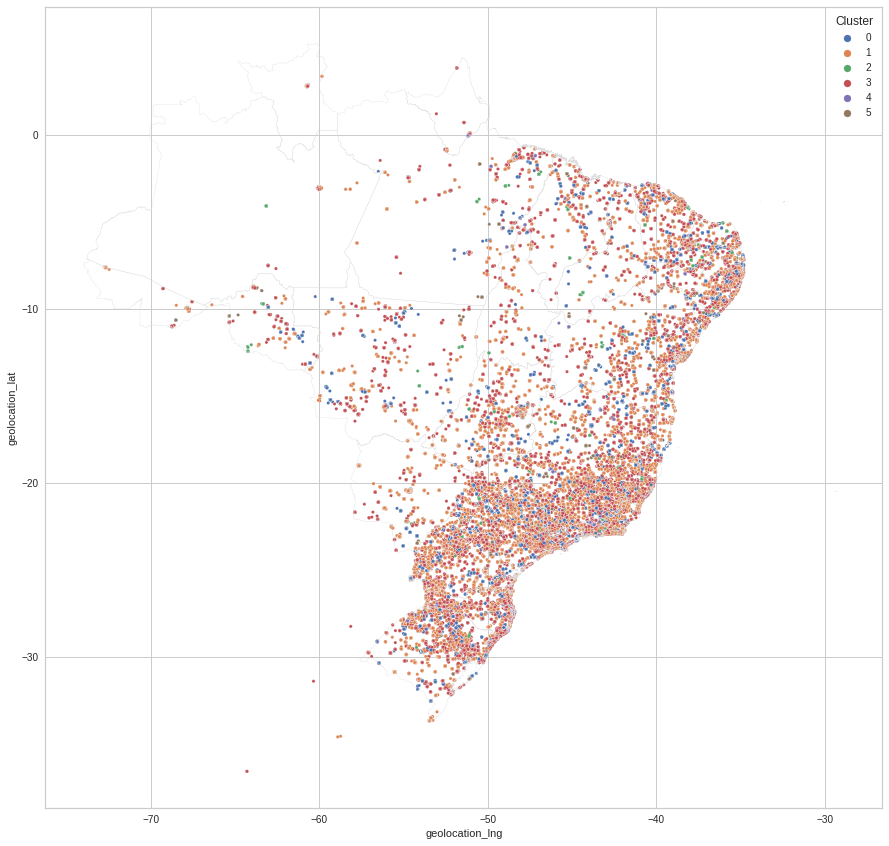

In [92]:
if config["geo"]["all"]:
    ax = brazil_geo.plot(
        figsize=(15, 15), color="none", edgecolor="gainsboro", zorder=3)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=geo_merged,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)


***
### 5.3.3 Per cluster visualization

In [93]:
if config["geo"]["per_cluster"]:
    cluster_0 = geo_merged[geo_merged["Cluster"] == 0]
    cluster_1 = geo_merged[geo_merged["Cluster"] == 1]
    cluster_2 = geo_merged[geo_merged["Cluster"] == 2]
    cluster_3 = geo_merged[geo_merged["Cluster"] == 3]
    cluster_4 = geo_merged[geo_merged["Cluster"] == 4]
    cluster_5 = geo_merged[geo_merged["Cluster"] == 5]

    cluster_1_3 = geo_merged[(
        geo_merged["Cluster"] == 1) | (geo_merged["Cluster"] == 3)]


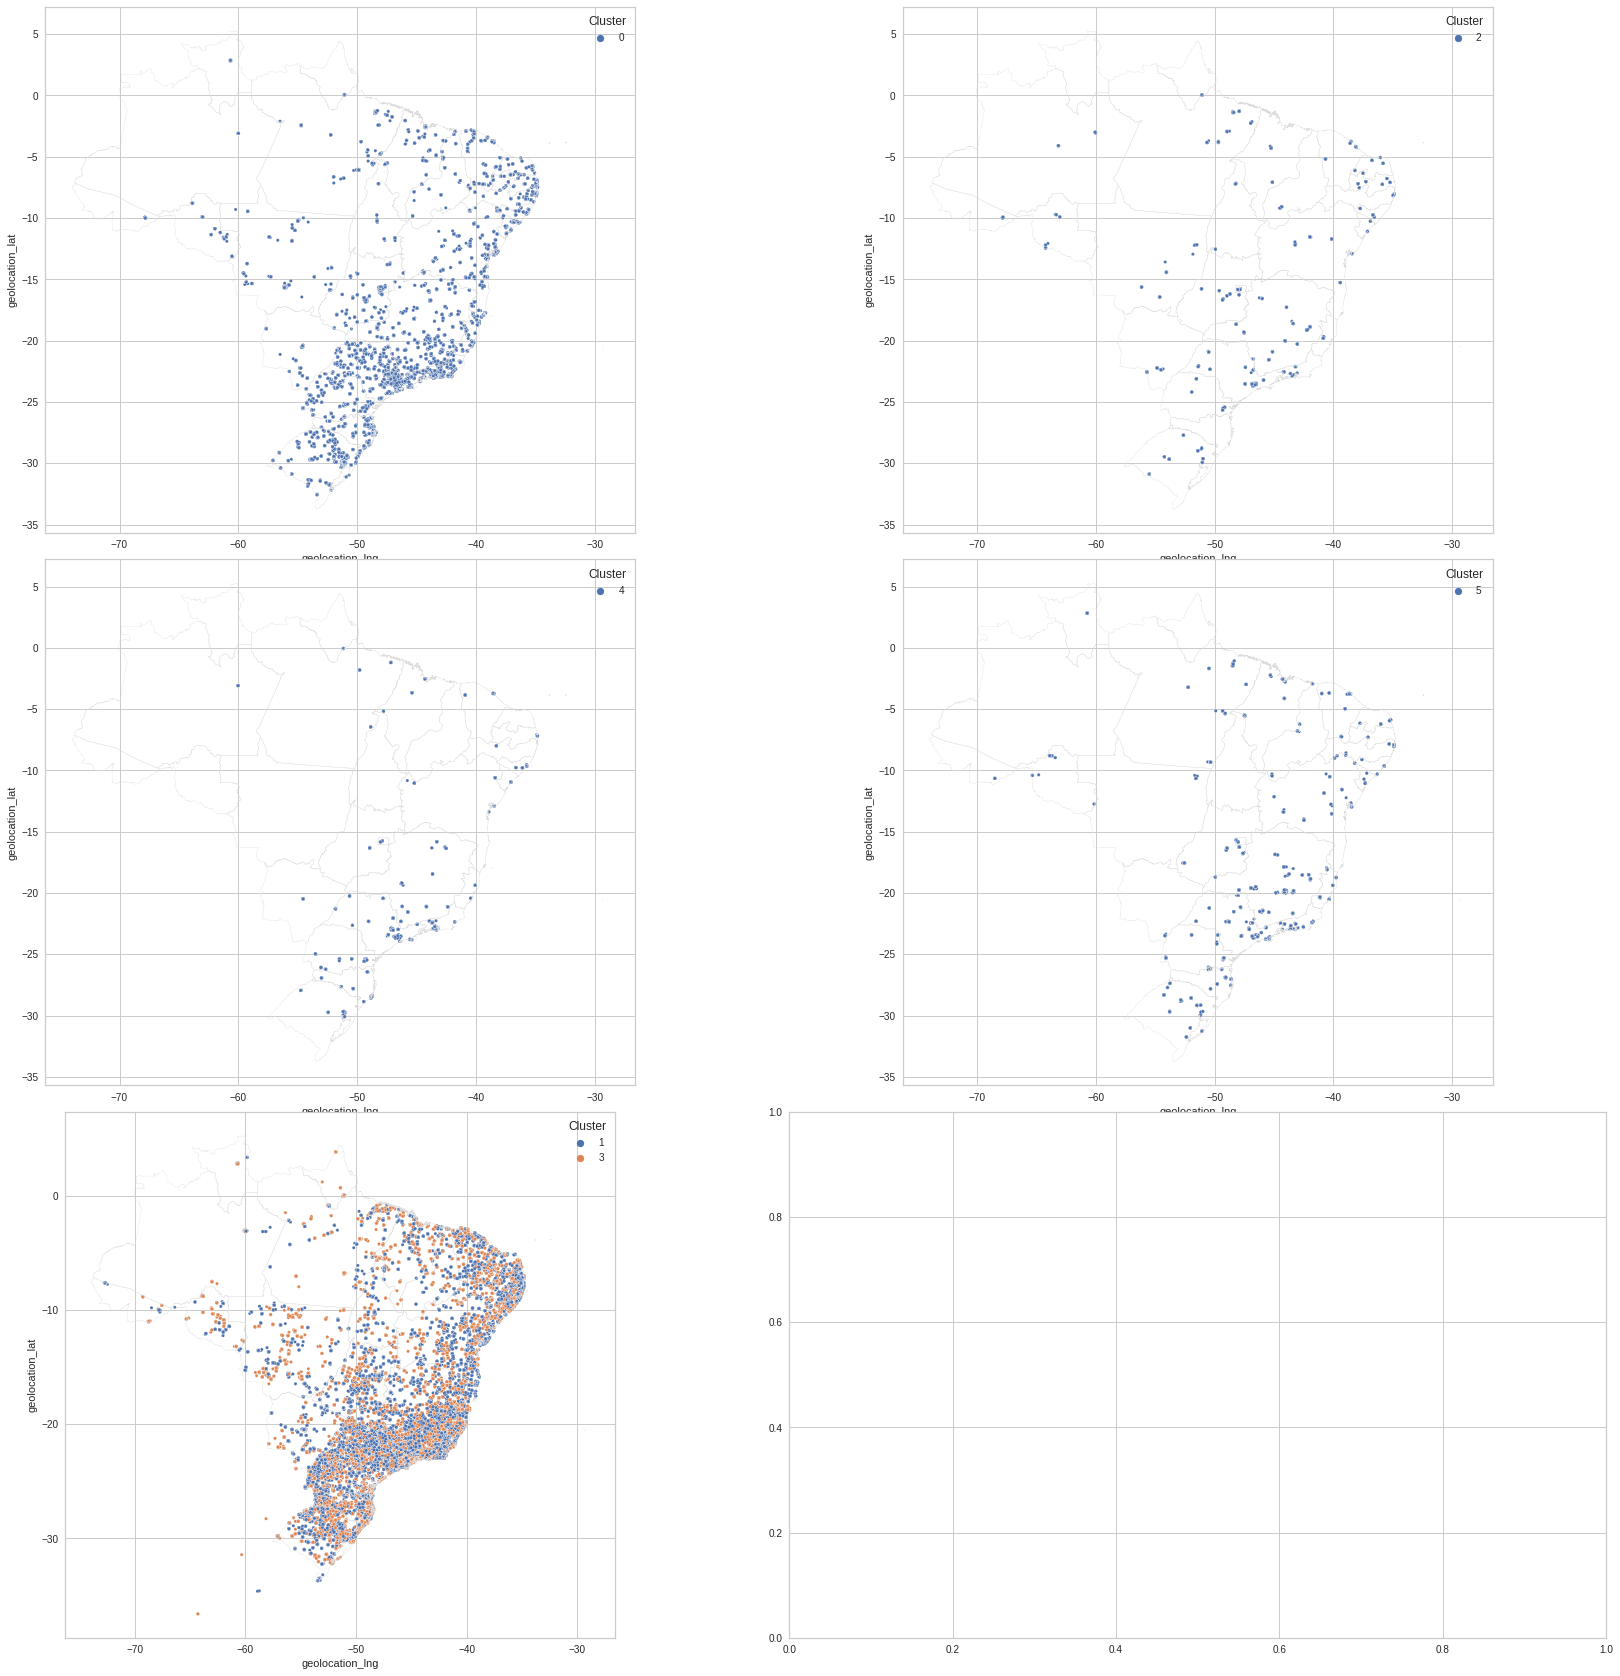

In [94]:
if config["geo"]["per_cluster"]:
    plt.subplots(3, 2, figsize=(30, 30))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    ax = plt.subplot(3, 2, 1)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=cluster_0,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 2)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=cluster_2,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 3)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=cluster_4,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 4)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=cluster_5,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)

    ax = plt.subplot(3, 2, 5)
    brazil_geo.plot(color="none", edgecolor="gainsboro", zorder=3, ax=ax)
    kws = {"s": 10, "facecolor": "none", "linewidth": 0.2}
    sns.scatterplot(
        data=cluster_1_3,
        x="geolocation_lng",
        y="geolocation_lat", ax=ax, hue="Cluster", palette="deep", **kws)


***
## 5.4 Maintenance

In [95]:
if config["maintenance"]["do"]:
    global_data.loc[:, "order_purchase_timestamp"] = data.loc[
        :,
        "order_purchase_timestamp"]
    global_data.loc[:, "order_purchase_timestamp"] = global_data.loc[
        :,
        "order_purchase_timestamp"].apply(pd.to_datetime)


In [96]:
if config["maintenance"]["do"]:
    global_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105786 entries, 0 to 111704
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   customer_zip_code_prefix        105786 non-null  int64         
 1   review_score                    105786 non-null  int64         
 2   payment_sequential              105786 non-null  int64         
 3   payment_installments            105786 non-null  float64       
 4   payment_value                   105786 non-null  float64       
 5   order_item_id                   105786 non-null  int64         
 6   price                           105786 non-null  float64       
 7   freight_value                   105786 non-null  float64       
 8   product_name_lenght             105786 non-null  float64       
 9   product_description_lenght      105786 non-null  float64       
 10  product_photos_qty              105786 non-null  float64

In [97]:
if config["maintenance"]["do"]:
    global_data.head()


In [98]:


def get_entire_period(dataset, temporal_index):
    return ceil(
        (dataset[temporal_index].max() - dataset[temporal_index].min()) /
        np.timedelta64(1, 'M'))


In [99]:


def get_frame_(dataset, temporal_index, start, period):
    temporal_index = dataset[temporal_index]
    end = start + pd.DateOffset(months=period)

    frame = dataset[(start <= temporal_index) & (temporal_index < end)]

    return frame


In [100]:


def kmeans_eval(dataset, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(dataset)
    labels = kmeans.labels_
    return labels


In [101]:


def rolling_eval_(
    dataset, features,
    temporal_index,
    n_clusters,
    initial_period,
    offset_month,
    key_index
):
    entire_period = get_entire_period(dataset, temporal_index)
    begin = dataset[temporal_index].min()
    ari_scores = []

    ref_period = get_frame_(
        dataset=dataset.copy(),
        temporal_index=temporal_index,
        start=begin,
        period=initial_period)
    ref_period.drop_duplicates(subset=["customer_id"], inplace=True)

    ref_labels = kmeans_eval(
        dataset=ref_period[features],
        n_clusters=n_clusters)

    for offset in np.arange(0, entire_period, offset_month):
        current_period = get_frame_(
            dataset=dataset,
            temporal_index=temporal_index,
            start=begin,
            period=initial_period + offset)
        current_period = current_period[
            current_period[key_index].isin(ref_period[key_index])
            ]
        current_period.drop_duplicates(subset=["customer_id"], inplace=True)

        current_labels = kmeans_eval(
            dataset=current_period[features], n_clusters=n_clusters)

        current_ari = adjusted_rand_score(ref_labels, current_labels)
        ari_scores.append((offset, current_ari))

    return ari_scores


In [102]:


if config["maintenance"]["do"]:
    global_data_preproc = preprocess_data(global_data)
    global_data_preproc["customer_id"] = global_data["customer_id"]
    global_data_preproc["order_purchase_timestamp"] = global_data[
        "order_purchase_timestamp"
        ]
    temp = global_data_preproc.drop_duplicates(
        subset=["customer_id"], inplace=False)


In [103]:
scores = None
if config["maintenance"]["do"]:
    scores = rolling_eval_(
        global_data_preproc,
        features=[
            "price", "freight_value", "product_weight_g",
            "product_volume_cm3", "price_sum", "frequency", "recency"],
        temporal_index="order_purchase_timestamp",
        n_clusters=6,
        initial_period=12, offset_month=2, key_index="customer_id")
scores


[(0, 1.0),
 (2, 0.9863891476753348),
 (4, 0.9774417152649881),
 (6, 0.9700059484835476),
 (8, 0.9660462829473425),
 (10, 0.9621679223970603),
 (12, 0.959440875148979),
 (14, 0.959440875148979),
 (16, 0.959440875148979),
 (18, 0.959440875148979),
 (20, 0.959440875148979),
 (22, 0.959440875148979)]

Text(0, 0.5, 'ARI')

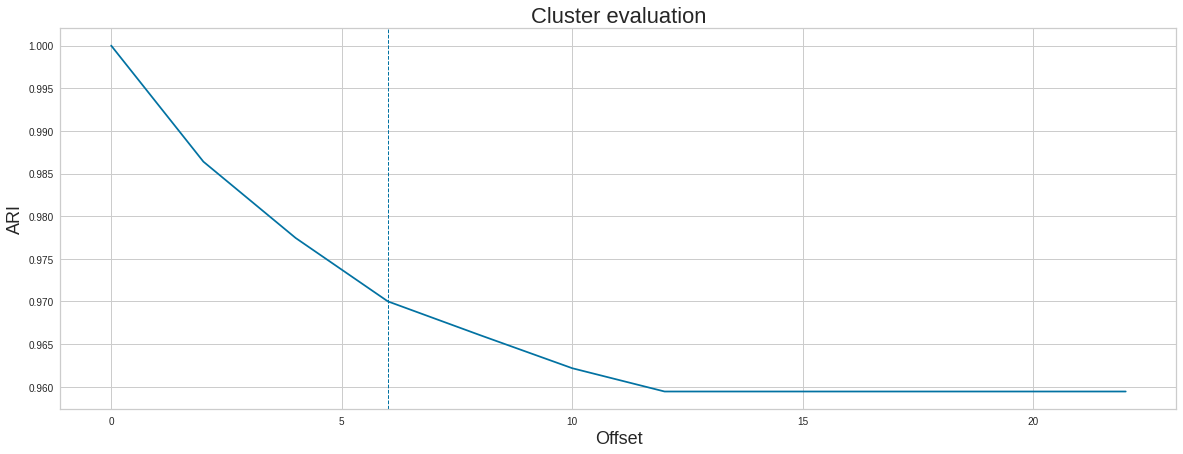

In [104]:
scores = pd.DataFrame(data=scores, columns=["offset", "ARI"])


plt.figure(figsize=(20, 7))
plt.title("Cluster evaluation", fontsize=22)
ax = sns.lineplot(data=scores, x="offset", y="ARI")

# minima = scores.iloc[scores["ARI"].idxmin()]["offset"]
# plt.axvline(minima, 0, scores["ARI"].max(), linestyle="--", linewidth=1)
plt.axvline(6, linestyle="--", linewidth=1)

plt.xlabel("Offset", fontsize=18)
plt.ylabel("ARI", fontsize=18)
